In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.metrics import roc_curve, auc
from tqdm import tqdm
from backbone1 import DenseNet201
from backbone2 import ResNet152d
from focal import FocalLoss
from dataloader import create_dataloader
from metric import Metric
from ctran2_1 import CTranEncoder3
torch.cuda.empty_cache()
from sklearn.metrics import precision_recall_curve, roc_auc_score, f1_score
from tabulate import tabulate
# from torchsummary import summary

# Set device to GPU if available, else use CPU
device = torch.device("cuda")
print(f"Current device: {torch.cuda.get_device_name(torch.cuda.current_device())}" if torch.cuda.is_available() else "Current device: CPU")

Current device: NVIDIA RTX A6000


In [2]:
# Define hyperparameters
batch_size = 32
num_epochs = 200
learning_rate = 0.000001
image_size = 384
num_workers = 8
num_labels = 20
num_layers = 6
embed_dim = 960
mlp_dim = 1024
thresholds = [0.5] * num_labels
num_classes = 20
data_dir = '../data'

In [3]:
# Create dataloaders
train_dataloader = create_dataloader(data_dir=data_dir, batch_size=batch_size, num_workers=num_workers, size=image_size, phase='train')
val_dataloader = create_dataloader(data_dir=data_dir, batch_size=batch_size, num_workers=num_workers, size=image_size, phase='val')

384
384


In [4]:
# Define model and optimizer
backbone1 = DenseNet201(num_classes=num_classes, embed_dim=embed_dim)
backbone2 = ResNet152d(num_classes=num_classes, embed_dim=embed_dim)
model = CTranEncoder3(num_classes=num_classes, embed_dim=embed_dim, num_layers=num_layers, num_heads=num_workers, 
                      mlp_dim=mlp_dim, backbone1=backbone1, backbone2=backbone2)
model.to(device)

# Wrap your model with DataParallel
# model = nn.DataParallel(model, device_ids=[0, 1, 2, 3])
criterion = nn.BCEWithLogitsLoss()
# criterion = FocalLoss(gamma=2, alpha=0.25, reduction='mean')

# Create a single optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=1e-6)

# Create a single scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
#scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-3, epochs= num_epochs, steps_per_epoch=len(train_dataloader))

/home/deependra/project/rfmidc/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/deependra/project/rfmidc/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
# Initialize Metric class
metric = Metric(num_classes=num_classes)

# create empty lists to store predicted probabilities and true labels for each epoch
val_preds_all, val_labels_all = [], []

# define the epochs at which to plot the ROC curve
roc_epochs = [5,10,20,30,40,50,60,70,80,90,100,120,140,160,180,200]

# create empty lists to store ROC data for each epoch
roc_fpr = []
roc_tpr = []
roc_auc = []
f1_arr = []
loss_arr = []
model_arr = []
max_ms = [0,0,0]
a,b = 0.4,0.6

# Train and evaluate model
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    print('-' * 10)

    # Train phase
    model.train()
    for images, labels in tqdm(train_dataloader):
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels) 
        outputs = torch.sigmoid(outputs)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Compute metrics on train set
        with torch.no_grad():
            metric.update(outputs, labels,0)
    
    # Print metrics on train set 1
    ml_f1_score, map_score, auc_score, ml_map_score, ml_auc_score, ml_score, bin_auc, model_score, bin_f1_score = metric.compute(1)
    print("DenseNet201:\n",f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, ML mAP: {ml_map_score:.4f}, ML F1: {ml_f1_score:.4f}, ML AUC: {ml_auc_score:.4f}, ML Score: {ml_score:.4f}, Bin AUC: {bin_auc:.4f}, Model Score: {model_score:.4f}, Bin F1: {bin_f1_score:.4f}")
    
    # Reset Metric class for evaluation
    metric.reset()
    del images
    del labels
    del outputs
    torch.cuda.empty_cache() 

    # Evaluate model on validation set
    model.eval()
    running_loss = 0.0
    val_preds, val_labels = [], []
    with torch.no_grad():
        for images, labels in tqdm(val_dataloader):
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels) 
            outputs = torch.sigmoid(outputs)

            # Calculate weighted average loss
            running_loss += loss.item()
            
            # append the predicted probabilities and true labels to lists for calculating ROC AUC score later
            val_preds += outputs.tolist()
            val_labels += labels.tolist()
            metric.update(outputs, labels, 1)

 
        # Print metrics on validation set
        ml_f1_score, map_score, auc_score, ml_map_score, ml_auc_score, ml_score, bin_auc, model_score, bin_f1_score = metric.compute(0)
        print(f"Val - Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, ML mAP: {ml_map_score:.4f}, ML F1: {ml_f1_score:.4f}, ML AUC: {ml_auc_score:.4f}, ML Score: {ml_score:.4f}, Bin AUC: {bin_auc:.4f}, Model Score: {model_score:.4f}, Bin F1: {bin_f1_score:.4f}")
        
        f1_arr.append(ml_f1_score)
        model_arr.append(model_score)
        loss_arr.append(running_loss / len(val_dataloader))
        
        if max_ms[0] < model_score: 
            max_ms[0] = model_score
            max_ms[1] = epoch
            max_ms[2] = optimizer.param_groups[0]['lr']

        # append the predicted probabilities and true labels for this epoch to the lists for all epochs
        val_preds_all.append(val_preds)
        val_labels_all.append(val_labels)

        # check if the current epoch is in the list of epochs to plot ROC curve
        if epoch+1 in roc_epochs:
            # calculate ROC curve and AUC score for validation set
            fpr, tpr, roc_thresholds = roc_curve(np.concatenate(val_labels_all).ravel(), np.concatenate(val_preds_all).ravel())
            roc_fpr.append(fpr)
            roc_tpr.append(tpr)
            roc_auc.append(auc(fpr, tpr))

        print() # empty line for spacing    
        
        # Reset Metric class for next epoch
        metric.reset()
        del images
        del labels
        del outputs
        torch.cuda.empty_cache()   
    
    # Step the learning rate scheduler
    scheduler.step()     

Epoch 1/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.12it/s]


DenseNet201:
 Epoch [1/200], Loss: 0.2644, ML mAP: 0.0958, ML F1: 0.0193, ML AUC: 0.5629, ML Score: 0.3294, Bin AUC: 0.7222, Model Score: 0.5258, Bin F1: 0.2353


100%|██████████| 14/14 [00:06<00:00,  2.28it/s]


Val - Epoch [1/200], Loss: 0.2070, ML mAP: 0.1601, ML F1: 0.0075, ML AUC: 0.7170, ML Score: 0.4386, Bin AUC: 0.4211, Model Score: 0.4298, Bin F1: 0.0000

Epoch 2/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.19it/s]


DenseNet201:
 Epoch [2/200], Loss: 0.2401, ML mAP: 0.2428, ML F1: 0.0442, ML AUC: 0.7697, ML Score: 0.5062, Bin AUC: 0.6275, Model Score: 0.5668, Bin F1: 0.0000


100%|██████████| 14/14 [00:06<00:00,  2.32it/s]


Val - Epoch [2/200], Loss: 0.1970, ML mAP: 0.3082, ML F1: 0.1254, ML AUC: 0.8551, ML Score: 0.5816, Bin AUC: 0.7368, Model Score: 0.6592, Bin F1: 0.0000

Epoch 3/200
----------


100%|██████████| 56/56 [00:48<00:00,  1.16it/s]


DenseNet201:
 Epoch [3/200], Loss: 0.2159, ML mAP: 0.3932, ML F1: 0.1739, ML AUC: 0.8563, ML Score: 0.6248, Bin AUC: 0.9474, Model Score: 0.7861, Bin F1: 0.0000


100%|██████████| 14/14 [00:06<00:00,  2.31it/s]


Val - Epoch [3/200], Loss: 0.2031, ML mAP: 0.4183, ML F1: 0.2352, ML AUC: 0.8750, ML Score: 0.6467, Bin AUC: 0.8421, Model Score: 0.7444, Bin F1: 0.0000

Epoch 4/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.17it/s]


DenseNet201:
 Epoch [4/200], Loss: 0.1681, ML mAP: 0.4954, ML F1: 0.3072, ML AUC: 0.8963, ML Score: 0.6958, Bin AUC: 0.5789, Model Score: 0.6374, Bin F1: 0.0000


100%|██████████| 14/14 [00:06<00:00,  2.31it/s]


Val - Epoch [4/200], Loss: 0.1994, ML mAP: 0.4618, ML F1: 0.2885, ML AUC: 0.8967, ML Score: 0.6792, Bin AUC: 0.9474, Model Score: 0.8133, Bin F1: 0.0000

Epoch 5/200
----------


100%|██████████| 56/56 [00:48<00:00,  1.16it/s]


DenseNet201:
 Epoch [5/200], Loss: 0.1468, ML mAP: 0.5837, ML F1: 0.4381, ML AUC: 0.9188, ML Score: 0.7512, Bin AUC: 1.0000, Model Score: 0.8756, Bin F1: 0.6667


100%|██████████| 14/14 [00:06<00:00,  2.31it/s]


Val - Epoch [5/200], Loss: 0.1924, ML mAP: 0.5207, ML F1: 0.3887, ML AUC: 0.9142, ML Score: 0.7174, Bin AUC: 0.9474, Model Score: 0.8324, Bin F1: 0.0000

Epoch 6/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.17it/s]


DenseNet201:
 Epoch [6/200], Loss: 0.1470, ML mAP: 0.6484, ML F1: 0.5141, ML AUC: 0.9348, ML Score: 0.7916, Bin AUC: 0.9722, Model Score: 0.8819, Bin F1: 0.5000


100%|██████████| 14/14 [00:06<00:00,  2.27it/s]


Val - Epoch [6/200], Loss: 0.1916, ML mAP: 0.5403, ML F1: 0.4177, ML AUC: 0.9185, ML Score: 0.7294, Bin AUC: 0.8947, Model Score: 0.8121, Bin F1: 0.0000

Epoch 7/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.17it/s]


DenseNet201:
 Epoch [7/200], Loss: 0.1265, ML mAP: 0.7304, ML F1: 0.5889, ML AUC: 0.9482, ML Score: 0.8393, Bin AUC: 1.0000, Model Score: 0.9197, Bin F1: 0.8000


100%|██████████| 14/14 [00:06<00:00,  2.32it/s]


Val - Epoch [7/200], Loss: 0.1857, ML mAP: 0.5648, ML F1: 0.4677, ML AUC: 0.9227, ML Score: 0.7438, Bin AUC: 0.8947, Model Score: 0.8192, Bin F1: 0.0000

Epoch 8/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.18it/s]


DenseNet201:
 Epoch [8/200], Loss: 0.1612, ML mAP: 0.7610, ML F1: 0.6347, ML AUC: 0.9568, ML Score: 0.8589, Bin AUC: 1.0000, Model Score: 0.9294, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.29it/s]


Val - Epoch [8/200], Loss: 0.1738, ML mAP: 0.5675, ML F1: 0.4674, ML AUC: 0.9225, ML Score: 0.7450, Bin AUC: 0.9474, Model Score: 0.8462, Bin F1: 0.0000

Epoch 9/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.17it/s]


DenseNet201:
 Epoch [9/200], Loss: 0.0717, ML mAP: 0.7799, ML F1: 0.6528, ML AUC: 0.9601, ML Score: 0.8700, Bin AUC: 0.9722, Model Score: 0.9211, Bin F1: 0.6667


100%|██████████| 14/14 [00:06<00:00,  2.27it/s]


Val - Epoch [9/200], Loss: 0.1721, ML mAP: 0.5816, ML F1: 0.4892, ML AUC: 0.9275, ML Score: 0.7546, Bin AUC: 0.9474, Model Score: 0.8510, Bin F1: 0.0000

Epoch 10/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.17it/s]


DenseNet201:
 Epoch [10/200], Loss: 0.1306, ML mAP: 0.8015, ML F1: 0.6640, ML AUC: 0.9639, ML Score: 0.8827, Bin AUC: 1.0000, Model Score: 0.9413, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.30it/s]


Val - Epoch [10/200], Loss: 0.1709, ML mAP: 0.5866, ML F1: 0.4959, ML AUC: 0.9273, ML Score: 0.7569, Bin AUC: 0.9474, Model Score: 0.8521, Bin F1: 0.0000

Epoch 11/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.17it/s]


DenseNet201:
 Epoch [11/200], Loss: 0.2373, ML mAP: 0.7401, ML F1: 0.6557, ML AUC: 0.9547, ML Score: 0.8474, Bin AUC: 1.0000, Model Score: 0.9237, Bin F1: 0.6667


100%|██████████| 14/14 [00:06<00:00,  2.32it/s]


Val - Epoch [11/200], Loss: 0.1753, ML mAP: 0.5379, ML F1: 0.4275, ML AUC: 0.8931, ML Score: 0.7155, Bin AUC: 0.7895, Model Score: 0.7525, Bin F1: 0.0000

Epoch 12/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.17it/s]


DenseNet201:
 Epoch [12/200], Loss: 0.1597, ML mAP: 0.7249, ML F1: 0.6344, ML AUC: 0.9499, ML Score: 0.8374, Bin AUC: 1.0000, Model Score: 0.9187, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.31it/s]


Val - Epoch [12/200], Loss: 0.1904, ML mAP: 0.5503, ML F1: 0.4325, ML AUC: 0.9163, ML Score: 0.7333, Bin AUC: 0.9474, Model Score: 0.8403, Bin F1: 0.0000

Epoch 13/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.17it/s]


DenseNet201:
 Epoch [13/200], Loss: 0.1637, ML mAP: 0.8060, ML F1: 0.7198, ML AUC: 0.9657, ML Score: 0.8858, Bin AUC: 1.0000, Model Score: 0.9429, Bin F1: 0.0000


100%|██████████| 14/14 [00:06<00:00,  2.29it/s]


Val - Epoch [13/200], Loss: 0.1620, ML mAP: 0.5869, ML F1: 0.5200, ML AUC: 0.9265, ML Score: 0.7567, Bin AUC: 1.0000, Model Score: 0.8784, Bin F1: 0.0000

Epoch 14/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.17it/s]


DenseNet201:
 Epoch [14/200], Loss: 0.1555, ML mAP: 0.8198, ML F1: 0.7461, ML AUC: 0.9698, ML Score: 0.8948, Bin AUC: 1.0000, Model Score: 0.9474, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.29it/s]


Val - Epoch [14/200], Loss: 0.1646, ML mAP: 0.5955, ML F1: 0.5513, ML AUC: 0.9298, ML Score: 0.7626, Bin AUC: 1.0000, Model Score: 0.8813, Bin F1: 0.0000

Epoch 15/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.18it/s]


DenseNet201:
 Epoch [15/200], Loss: 0.1122, ML mAP: 0.8719, ML F1: 0.8035, ML AUC: 0.9786, ML Score: 0.9252, Bin AUC: 0.9167, Model Score: 0.9209, Bin F1: 0.6667


100%|██████████| 14/14 [00:06<00:00,  2.27it/s]


Val - Epoch [15/200], Loss: 0.1976, ML mAP: 0.5902, ML F1: 0.5070, ML AUC: 0.9086, ML Score: 0.7494, Bin AUC: 0.9474, Model Score: 0.8484, Bin F1: 0.0000

Epoch 16/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.18it/s]


DenseNet201:
 Epoch [16/200], Loss: 0.2199, ML mAP: 0.8775, ML F1: 0.8103, ML AUC: 0.9802, ML Score: 0.9288, Bin AUC: 0.7895, Model Score: 0.8592, Bin F1: 0.0000


100%|██████████| 14/14 [00:06<00:00,  2.32it/s]


Val - Epoch [16/200], Loss: 0.1725, ML mAP: 0.6111, ML F1: 0.5618, ML AUC: 0.9258, ML Score: 0.7684, Bin AUC: 1.0000, Model Score: 0.8842, Bin F1: 0.0000

Epoch 17/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.18it/s]


DenseNet201:
 Epoch [17/200], Loss: 0.1039, ML mAP: 0.8911, ML F1: 0.8206, ML AUC: 0.9839, ML Score: 0.9375, Bin AUC: 0.8421, Model Score: 0.8898, Bin F1: 0.0000


100%|██████████| 14/14 [00:06<00:00,  2.29it/s]


Val - Epoch [17/200], Loss: 0.1847, ML mAP: 0.6119, ML F1: 0.5739, ML AUC: 0.9228, ML Score: 0.7673, Bin AUC: 0.9474, Model Score: 0.8574, Bin F1: 0.0000

Epoch 18/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.17it/s]


DenseNet201:
 Epoch [18/200], Loss: 0.1318, ML mAP: 0.9075, ML F1: 0.8396, ML AUC: 0.9863, ML Score: 0.9469, Bin AUC: 1.0000, Model Score: 0.9734, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.31it/s]


Val - Epoch [18/200], Loss: 0.1786, ML mAP: 0.6291, ML F1: 0.5923, ML AUC: 0.9263, ML Score: 0.7777, Bin AUC: 0.9474, Model Score: 0.8625, Bin F1: 0.0000

Epoch 19/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.17it/s]


DenseNet201:
 Epoch [19/200], Loss: 0.1365, ML mAP: 0.9273, ML F1: 0.8758, ML AUC: 0.9896, ML Score: 0.9584, Bin AUC: 1.0000, Model Score: 0.9792, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.30it/s]


Val - Epoch [19/200], Loss: 0.1922, ML mAP: 0.6464, ML F1: 0.5903, ML AUC: 0.9371, ML Score: 0.7918, Bin AUC: 0.9474, Model Score: 0.8696, Bin F1: 0.0000

Epoch 20/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.17it/s]


DenseNet201:
 Epoch [20/200], Loss: 0.1080, ML mAP: 0.9336, ML F1: 0.8815, ML AUC: 0.9896, ML Score: 0.9616, Bin AUC: 1.0000, Model Score: 0.9808, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.27it/s]


Val - Epoch [20/200], Loss: 0.1749, ML mAP: 0.6422, ML F1: 0.6035, ML AUC: 0.9360, ML Score: 0.7891, Bin AUC: 0.9474, Model Score: 0.8682, Bin F1: 0.0000

Epoch 21/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.18it/s]


DenseNet201:
 Epoch [21/200], Loss: 0.2139, ML mAP: 0.9502, ML F1: 0.8993, ML AUC: 0.9933, ML Score: 0.9718, Bin AUC: 1.0000, Model Score: 0.9859, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.30it/s]


Val - Epoch [21/200], Loss: 0.1679, ML mAP: 0.6281, ML F1: 0.5897, ML AUC: 0.9321, ML Score: 0.7801, Bin AUC: 1.0000, Model Score: 0.8900, Bin F1: 0.0000

Epoch 22/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.18it/s]


DenseNet201:
 Epoch [22/200], Loss: 0.0653, ML mAP: 0.9594, ML F1: 0.9104, ML AUC: 0.9945, ML Score: 0.9769, Bin AUC: 1.0000, Model Score: 0.9885, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.30it/s]


Val - Epoch [22/200], Loss: 0.1800, ML mAP: 0.6389, ML F1: 0.5881, ML AUC: 0.9283, ML Score: 0.7836, Bin AUC: 1.0000, Model Score: 0.8918, Bin F1: 1.0000

Epoch 23/200
----------


100%|██████████| 56/56 [00:48<00:00,  1.17it/s]


DenseNet201:
 Epoch [23/200], Loss: 0.0998, ML mAP: 0.9652, ML F1: 0.9190, ML AUC: 0.9959, ML Score: 0.9806, Bin AUC: 1.0000, Model Score: 0.9903, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.30it/s]


Val - Epoch [23/200], Loss: 0.1682, ML mAP: 0.6364, ML F1: 0.6253, ML AUC: 0.9294, ML Score: 0.7829, Bin AUC: 1.0000, Model Score: 0.8914, Bin F1: 0.0000

Epoch 24/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.17it/s]


DenseNet201:
 Epoch [24/200], Loss: 0.1033, ML mAP: 0.9693, ML F1: 0.9263, ML AUC: 0.9965, ML Score: 0.9829, Bin AUC: 1.0000, Model Score: 0.9915, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.28it/s]


Val - Epoch [24/200], Loss: 0.1756, ML mAP: 0.6423, ML F1: 0.6197, ML AUC: 0.9304, ML Score: 0.7863, Bin AUC: 1.0000, Model Score: 0.8932, Bin F1: 0.0000

Epoch 25/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.18it/s]


DenseNet201:
 Epoch [25/200], Loss: 0.0628, ML mAP: 0.9756, ML F1: 0.9343, ML AUC: 0.9966, ML Score: 0.9861, Bin AUC: 1.0000, Model Score: 0.9930, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.30it/s]


Val - Epoch [25/200], Loss: 0.1705, ML mAP: 0.6512, ML F1: 0.6179, ML AUC: 0.9278, ML Score: 0.7895, Bin AUC: 1.0000, Model Score: 0.8948, Bin F1: 1.0000

Epoch 26/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.17it/s]


DenseNet201:
 Epoch [26/200], Loss: 0.0822, ML mAP: 0.9752, ML F1: 0.9410, ML AUC: 0.9970, ML Score: 0.9861, Bin AUC: 1.0000, Model Score: 0.9931, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.31it/s]


Val - Epoch [26/200], Loss: 0.1718, ML mAP: 0.6457, ML F1: 0.6243, ML AUC: 0.9323, ML Score: 0.7890, Bin AUC: 1.0000, Model Score: 0.8945, Bin F1: 0.0000

Epoch 27/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.18it/s]


DenseNet201:
 Epoch [27/200], Loss: 0.1093, ML mAP: 0.9786, ML F1: 0.9437, ML AUC: 0.9975, ML Score: 0.9880, Bin AUC: 0.8947, Model Score: 0.9414, Bin F1: 0.0000


100%|██████████| 14/14 [00:06<00:00,  2.29it/s]


Val - Epoch [27/200], Loss: 0.1737, ML mAP: 0.6532, ML F1: 0.6334, ML AUC: 0.9325, ML Score: 0.7928, Bin AUC: 1.0000, Model Score: 0.8964, Bin F1: 1.0000

Epoch 28/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.17it/s]


DenseNet201:
 Epoch [28/200], Loss: 0.0297, ML mAP: 0.9803, ML F1: 0.9481, ML AUC: 0.9978, ML Score: 0.9891, Bin AUC: 1.0000, Model Score: 0.9945, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.30it/s]


Val - Epoch [28/200], Loss: 0.1763, ML mAP: 0.6456, ML F1: 0.6331, ML AUC: 0.9331, ML Score: 0.7893, Bin AUC: 1.0000, Model Score: 0.8947, Bin F1: 0.0000

Epoch 29/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.17it/s]


DenseNet201:
 Epoch [29/200], Loss: 0.1021, ML mAP: 0.9798, ML F1: 0.9446, ML AUC: 0.9976, ML Score: 0.9887, Bin AUC: 0.9474, Model Score: 0.9680, Bin F1: 0.0000


100%|██████████| 14/14 [00:06<00:00,  2.27it/s]


Val - Epoch [29/200], Loss: 0.1716, ML mAP: 0.6483, ML F1: 0.6279, ML AUC: 0.9323, ML Score: 0.7903, Bin AUC: 1.0000, Model Score: 0.8952, Bin F1: 1.0000

Epoch 30/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.17it/s]


DenseNet201:
 Epoch [30/200], Loss: 0.0387, ML mAP: 0.9820, ML F1: 0.9490, ML AUC: 0.9976, ML Score: 0.9898, Bin AUC: 1.0000, Model Score: 0.9949, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.28it/s]


Val - Epoch [30/200], Loss: 0.1746, ML mAP: 0.6479, ML F1: 0.6217, ML AUC: 0.9314, ML Score: 0.7896, Bin AUC: 1.0000, Model Score: 0.8948, Bin F1: 1.0000

Epoch 31/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.17it/s]


DenseNet201:
 Epoch [31/200], Loss: 0.2319, ML mAP: 0.9515, ML F1: 0.9069, ML AUC: 0.9935, ML Score: 0.9725, Bin AUC: 1.0000, Model Score: 0.9862, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.30it/s]


Val - Epoch [31/200], Loss: 0.2054, ML mAP: 0.6284, ML F1: 0.5794, ML AUC: 0.9355, ML Score: 0.7820, Bin AUC: 1.0000, Model Score: 0.8910, Bin F1: 0.0000

Epoch 32/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.18it/s]


DenseNet201:
 Epoch [32/200], Loss: 0.2350, ML mAP: 0.9086, ML F1: 0.8509, ML AUC: 0.9869, ML Score: 0.9477, Bin AUC: 1.0000, Model Score: 0.9739, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.30it/s]


Val - Epoch [32/200], Loss: 0.1796, ML mAP: 0.5896, ML F1: 0.5177, ML AUC: 0.9090, ML Score: 0.7493, Bin AUC: 0.9474, Model Score: 0.8483, Bin F1: 0.0000

Epoch 33/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.17it/s]


DenseNet201:
 Epoch [33/200], Loss: 0.1046, ML mAP: 0.9129, ML F1: 0.8534, ML AUC: 0.9866, ML Score: 0.9498, Bin AUC: 1.0000, Model Score: 0.9749, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.28it/s]


Val - Epoch [33/200], Loss: 0.1913, ML mAP: 0.6272, ML F1: 0.5971, ML AUC: 0.9246, ML Score: 0.7759, Bin AUC: 1.0000, Model Score: 0.8879, Bin F1: 1.0000

Epoch 34/200
----------


100%|██████████| 56/56 [00:48<00:00,  1.16it/s]


DenseNet201:
 Epoch [34/200], Loss: 0.0603, ML mAP: 0.9519, ML F1: 0.8953, ML AUC: 0.9933, ML Score: 0.9726, Bin AUC: 0.9722, Model Score: 0.9724, Bin F1: 0.0000


100%|██████████| 14/14 [00:06<00:00,  2.30it/s]


Val - Epoch [34/200], Loss: 0.2040, ML mAP: 0.6102, ML F1: 0.5620, ML AUC: 0.9300, ML Score: 0.7701, Bin AUC: 1.0000, Model Score: 0.8851, Bin F1: 1.0000

Epoch 35/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.17it/s]


DenseNet201:
 Epoch [35/200], Loss: 0.0745, ML mAP: 0.9484, ML F1: 0.8978, ML AUC: 0.9932, ML Score: 0.9708, Bin AUC: 1.0000, Model Score: 0.9854, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.29it/s]


Val - Epoch [35/200], Loss: 0.2160, ML mAP: 0.6250, ML F1: 0.5698, ML AUC: 0.9299, ML Score: 0.7775, Bin AUC: 1.0000, Model Score: 0.8887, Bin F1: 1.0000

Epoch 36/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.18it/s]


DenseNet201:
 Epoch [36/200], Loss: 0.0504, ML mAP: 0.9570, ML F1: 0.9033, ML AUC: 0.9944, ML Score: 0.9757, Bin AUC: 1.0000, Model Score: 0.9878, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.30it/s]


Val - Epoch [36/200], Loss: 0.2028, ML mAP: 0.6092, ML F1: 0.5709, ML AUC: 0.9219, ML Score: 0.7656, Bin AUC: 0.8947, Model Score: 0.8302, Bin F1: 0.0000

Epoch 37/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.17it/s]


DenseNet201:
 Epoch [37/200], Loss: 0.0719, ML mAP: 0.9674, ML F1: 0.9263, ML AUC: 0.9957, ML Score: 0.9816, Bin AUC: 0.8333, Model Score: 0.9075, Bin F1: 0.6667


100%|██████████| 14/14 [00:06<00:00,  2.27it/s]


Val - Epoch [37/200], Loss: 0.2308, ML mAP: 0.6173, ML F1: 0.5948, ML AUC: 0.9382, ML Score: 0.7778, Bin AUC: 0.9474, Model Score: 0.8626, Bin F1: 0.0000

Epoch 38/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.17it/s]


DenseNet201:
 Epoch [38/200], Loss: 0.0543, ML mAP: 0.9600, ML F1: 0.9210, ML AUC: 0.9945, ML Score: 0.9772, Bin AUC: 1.0000, Model Score: 0.9886, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.27it/s]


Val - Epoch [38/200], Loss: 0.2228, ML mAP: 0.6179, ML F1: 0.5749, ML AUC: 0.9276, ML Score: 0.7727, Bin AUC: 0.8947, Model Score: 0.8337, Bin F1: 0.0000

Epoch 39/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.17it/s]


DenseNet201:
 Epoch [39/200], Loss: 0.1340, ML mAP: 0.9620, ML F1: 0.9245, ML AUC: 0.9959, ML Score: 0.9789, Bin AUC: 1.0000, Model Score: 0.9895, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.31it/s]


Val - Epoch [39/200], Loss: 0.2293, ML mAP: 0.6427, ML F1: 0.5858, ML AUC: 0.9292, ML Score: 0.7860, Bin AUC: 1.0000, Model Score: 0.8930, Bin F1: 1.0000

Epoch 40/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.17it/s]


DenseNet201:
 Epoch [40/200], Loss: 0.0221, ML mAP: 0.9565, ML F1: 0.9119, ML AUC: 0.9928, ML Score: 0.9747, Bin AUC: 1.0000, Model Score: 0.9873, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.30it/s]


Val - Epoch [40/200], Loss: 0.2218, ML mAP: 0.6183, ML F1: 0.5440, ML AUC: 0.9256, ML Score: 0.7719, Bin AUC: 1.0000, Model Score: 0.8860, Bin F1: 0.0000

Epoch 41/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.17it/s]


DenseNet201:
 Epoch [41/200], Loss: 0.1992, ML mAP: 0.9759, ML F1: 0.9330, ML AUC: 0.9964, ML Score: 0.9862, Bin AUC: 1.0000, Model Score: 0.9931, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.32it/s]


Val - Epoch [41/200], Loss: 0.2416, ML mAP: 0.6102, ML F1: 0.5707, ML AUC: 0.9302, ML Score: 0.7702, Bin AUC: 1.0000, Model Score: 0.8851, Bin F1: 1.0000

Epoch 42/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.17it/s]


DenseNet201:
 Epoch [42/200], Loss: 0.1965, ML mAP: 0.9733, ML F1: 0.9395, ML AUC: 0.9968, ML Score: 0.9851, Bin AUC: 1.0000, Model Score: 0.9925, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.32it/s]


Val - Epoch [42/200], Loss: 0.2093, ML mAP: 0.6269, ML F1: 0.5822, ML AUC: 0.9266, ML Score: 0.7767, Bin AUC: 0.8947, Model Score: 0.8357, Bin F1: 0.0000

Epoch 43/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.18it/s]


DenseNet201:
 Epoch [43/200], Loss: 0.0984, ML mAP: 0.9781, ML F1: 0.9368, ML AUC: 0.9968, ML Score: 0.9874, Bin AUC: 1.0000, Model Score: 0.9937, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.31it/s]


Val - Epoch [43/200], Loss: 0.2105, ML mAP: 0.6348, ML F1: 0.5806, ML AUC: 0.9269, ML Score: 0.7809, Bin AUC: 0.9474, Model Score: 0.8641, Bin F1: 0.0000

Epoch 44/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.18it/s]


DenseNet201:
 Epoch [44/200], Loss: 0.1619, ML mAP: 0.9858, ML F1: 0.9517, ML AUC: 0.9980, ML Score: 0.9919, Bin AUC: 1.0000, Model Score: 0.9960, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.32it/s]


Val - Epoch [44/200], Loss: 0.2246, ML mAP: 0.6418, ML F1: 0.5861, ML AUC: 0.9266, ML Score: 0.7842, Bin AUC: 0.8947, Model Score: 0.8395, Bin F1: 0.0000

Epoch 45/200
----------


100%|██████████| 56/56 [00:48<00:00,  1.16it/s]


DenseNet201:
 Epoch [45/200], Loss: 0.0581, ML mAP: 0.9727, ML F1: 0.9426, ML AUC: 0.9969, ML Score: 0.9848, Bin AUC: 1.0000, Model Score: 0.9924, Bin F1: 0.6667


100%|██████████| 14/14 [00:06<00:00,  2.30it/s]


Val - Epoch [45/200], Loss: 0.2133, ML mAP: 0.6522, ML F1: 0.5930, ML AUC: 0.9308, ML Score: 0.7915, Bin AUC: 0.9474, Model Score: 0.8694, Bin F1: 0.0000

Epoch 46/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.17it/s]


DenseNet201:
 Epoch [46/200], Loss: 0.0398, ML mAP: 0.9852, ML F1: 0.9554, ML AUC: 0.9976, ML Score: 0.9914, Bin AUC: 0.9444, Model Score: 0.9679, Bin F1: 0.0000


100%|██████████| 14/14 [00:06<00:00,  2.32it/s]


Val - Epoch [46/200], Loss: 0.2104, ML mAP: 0.6295, ML F1: 0.5886, ML AUC: 0.9298, ML Score: 0.7796, Bin AUC: 0.8947, Model Score: 0.8372, Bin F1: 0.0000

Epoch 47/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.17it/s]


DenseNet201:
 Epoch [47/200], Loss: 0.1230, ML mAP: 0.9858, ML F1: 0.9581, ML AUC: 0.9982, ML Score: 0.9920, Bin AUC: 1.0000, Model Score: 0.9960, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.31it/s]


Val - Epoch [47/200], Loss: 0.2022, ML mAP: 0.6652, ML F1: 0.6281, ML AUC: 0.9390, ML Score: 0.8021, Bin AUC: 0.8947, Model Score: 0.8484, Bin F1: 0.0000

Epoch 48/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.17it/s]


DenseNet201:
 Epoch [48/200], Loss: 0.0723, ML mAP: 0.9761, ML F1: 0.9413, ML AUC: 0.9970, ML Score: 0.9865, Bin AUC: 1.0000, Model Score: 0.9933, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.28it/s]


Val - Epoch [48/200], Loss: 0.2191, ML mAP: 0.6526, ML F1: 0.6137, ML AUC: 0.9328, ML Score: 0.7927, Bin AUC: 1.0000, Model Score: 0.8964, Bin F1: 1.0000

Epoch 49/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.17it/s]


DenseNet201:
 Epoch [49/200], Loss: 0.0776, ML mAP: 0.9850, ML F1: 0.9573, ML AUC: 0.9988, ML Score: 0.9919, Bin AUC: 1.0000, Model Score: 0.9960, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.31it/s]


Val - Epoch [49/200], Loss: 0.2208, ML mAP: 0.6653, ML F1: 0.6163, ML AUC: 0.9354, ML Score: 0.8004, Bin AUC: 0.9474, Model Score: 0.8739, Bin F1: 0.6667

Epoch 50/200
----------


100%|██████████| 56/56 [00:48<00:00,  1.16it/s]


DenseNet201:
 Epoch [50/200], Loss: 0.2060, ML mAP: 0.9884, ML F1: 0.9634, ML AUC: 0.9988, ML Score: 0.9936, Bin AUC: 1.0000, Model Score: 0.9968, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.31it/s]


Val - Epoch [50/200], Loss: 0.2165, ML mAP: 0.6535, ML F1: 0.6121, ML AUC: 0.9338, ML Score: 0.7937, Bin AUC: 1.0000, Model Score: 0.8968, Bin F1: 1.0000

Epoch 51/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.18it/s]


DenseNet201:
 Epoch [51/200], Loss: 0.0701, ML mAP: 0.9919, ML F1: 0.9663, ML AUC: 0.9991, ML Score: 0.9955, Bin AUC: 1.0000, Model Score: 0.9977, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.31it/s]


Val - Epoch [51/200], Loss: 0.2405, ML mAP: 0.6485, ML F1: 0.5790, ML AUC: 0.9316, ML Score: 0.7901, Bin AUC: 0.9474, Model Score: 0.8687, Bin F1: 0.0000

Epoch 52/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.18it/s]


DenseNet201:
 Epoch [52/200], Loss: 0.2205, ML mAP: 0.9920, ML F1: 0.9667, ML AUC: 0.9988, ML Score: 0.9954, Bin AUC: 1.0000, Model Score: 0.9977, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.31it/s]


Val - Epoch [52/200], Loss: 0.2566, ML mAP: 0.6552, ML F1: 0.6019, ML AUC: 0.9332, ML Score: 0.7942, Bin AUC: 0.9474, Model Score: 0.8708, Bin F1: 0.0000

Epoch 53/200
----------


100%|██████████| 56/56 [00:48<00:00,  1.17it/s]


DenseNet201:
 Epoch [53/200], Loss: 0.2237, ML mAP: 0.9913, ML F1: 0.9660, ML AUC: 0.9989, ML Score: 0.9951, Bin AUC: 1.0000, Model Score: 0.9976, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.31it/s]


Val - Epoch [53/200], Loss: 0.2484, ML mAP: 0.6558, ML F1: 0.5801, ML AUC: 0.9350, ML Score: 0.7954, Bin AUC: 1.0000, Model Score: 0.8977, Bin F1: 0.0000

Epoch 54/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.17it/s]


DenseNet201:
 Epoch [54/200], Loss: 0.1033, ML mAP: 0.9908, ML F1: 0.9685, ML AUC: 0.9987, ML Score: 0.9947, Bin AUC: 1.0000, Model Score: 0.9974, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.31it/s]


Val - Epoch [54/200], Loss: 0.2585, ML mAP: 0.6523, ML F1: 0.5890, ML AUC: 0.9283, ML Score: 0.7903, Bin AUC: 0.9474, Model Score: 0.8688, Bin F1: 0.0000

Epoch 55/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.17it/s]


DenseNet201:
 Epoch [55/200], Loss: 0.0174, ML mAP: 0.9940, ML F1: 0.9700, ML AUC: 0.9994, ML Score: 0.9967, Bin AUC: 1.0000, Model Score: 0.9984, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.30it/s]


Val - Epoch [55/200], Loss: 0.2429, ML mAP: 0.6549, ML F1: 0.6161, ML AUC: 0.9308, ML Score: 0.7928, Bin AUC: 1.0000, Model Score: 0.8964, Bin F1: 1.0000

Epoch 56/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.18it/s]


DenseNet201:
 Epoch [56/200], Loss: 0.0235, ML mAP: 0.9952, ML F1: 0.9769, ML AUC: 0.9995, ML Score: 0.9973, Bin AUC: 1.0000, Model Score: 0.9987, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.30it/s]


Val - Epoch [56/200], Loss: 0.2400, ML mAP: 0.6435, ML F1: 0.6026, ML AUC: 0.9332, ML Score: 0.7884, Bin AUC: 0.9474, Model Score: 0.8679, Bin F1: 0.0000

Epoch 57/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.17it/s]


DenseNet201:
 Epoch [57/200], Loss: 0.0653, ML mAP: 0.9941, ML F1: 0.9776, ML AUC: 0.9994, ML Score: 0.9968, Bin AUC: 1.0000, Model Score: 0.9984, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.30it/s]


Val - Epoch [57/200], Loss: 0.2499, ML mAP: 0.6588, ML F1: 0.6015, ML AUC: 0.9328, ML Score: 0.7958, Bin AUC: 1.0000, Model Score: 0.8979, Bin F1: 0.0000

Epoch 58/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.18it/s]


DenseNet201:
 Epoch [58/200], Loss: 0.0935, ML mAP: 0.9930, ML F1: 0.9734, ML AUC: 0.9991, ML Score: 0.9961, Bin AUC: 0.7368, Model Score: 0.8665, Bin F1: 0.0000


100%|██████████| 14/14 [00:06<00:00,  2.31it/s]


Val - Epoch [58/200], Loss: 0.2563, ML mAP: 0.6588, ML F1: 0.5912, ML AUC: 0.9342, ML Score: 0.7965, Bin AUC: 0.9474, Model Score: 0.8719, Bin F1: 0.0000

Epoch 59/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.17it/s]


DenseNet201:
 Epoch [59/200], Loss: 0.0458, ML mAP: 0.9968, ML F1: 0.9811, ML AUC: 0.9996, ML Score: 0.9982, Bin AUC: 1.0000, Model Score: 0.9991, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.31it/s]


Val - Epoch [59/200], Loss: 0.2478, ML mAP: 0.6620, ML F1: 0.6117, ML AUC: 0.9354, ML Score: 0.7987, Bin AUC: 0.9474, Model Score: 0.8730, Bin F1: 0.0000

Epoch 60/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.18it/s]


DenseNet201:
 Epoch [60/200], Loss: 0.0207, ML mAP: 0.9956, ML F1: 0.9852, ML AUC: 0.9996, ML Score: 0.9976, Bin AUC: 1.0000, Model Score: 0.9988, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.31it/s]


Val - Epoch [60/200], Loss: 0.2808, ML mAP: 0.6566, ML F1: 0.5832, ML AUC: 0.9309, ML Score: 0.7938, Bin AUC: 0.9474, Model Score: 0.8706, Bin F1: 0.0000

Epoch 61/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.17it/s]


DenseNet201:
 Epoch [61/200], Loss: 0.0065, ML mAP: 0.9976, ML F1: 0.9850, ML AUC: 0.9998, ML Score: 0.9987, Bin AUC: 1.0000, Model Score: 0.9994, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.32it/s]


Val - Epoch [61/200], Loss: 0.2589, ML mAP: 0.6582, ML F1: 0.6048, ML AUC: 0.9321, ML Score: 0.7951, Bin AUC: 0.9474, Model Score: 0.8713, Bin F1: 0.0000

Epoch 62/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.17it/s]


DenseNet201:
 Epoch [62/200], Loss: 0.0035, ML mAP: 0.9972, ML F1: 0.9837, ML AUC: 0.9996, ML Score: 0.9984, Bin AUC: 1.0000, Model Score: 0.9992, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.31it/s]


Val - Epoch [62/200], Loss: 0.2637, ML mAP: 0.6565, ML F1: 0.6013, ML AUC: 0.9369, ML Score: 0.7967, Bin AUC: 1.0000, Model Score: 0.8984, Bin F1: 0.0000

Epoch 63/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.18it/s]


DenseNet201:
 Epoch [63/200], Loss: 0.0089, ML mAP: 0.9965, ML F1: 0.9824, ML AUC: 0.9997, ML Score: 0.9981, Bin AUC: 1.0000, Model Score: 0.9991, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.30it/s]


Val - Epoch [63/200], Loss: 0.2547, ML mAP: 0.6654, ML F1: 0.6021, ML AUC: 0.9333, ML Score: 0.7993, Bin AUC: 1.0000, Model Score: 0.8997, Bin F1: 1.0000

Epoch 64/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.17it/s]


DenseNet201:
 Epoch [64/200], Loss: 0.0353, ML mAP: 0.9987, ML F1: 0.9870, ML AUC: 0.9999, ML Score: 0.9993, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.31it/s]


Val - Epoch [64/200], Loss: 0.2630, ML mAP: 0.6577, ML F1: 0.5991, ML AUC: 0.9342, ML Score: 0.7960, Bin AUC: 1.0000, Model Score: 0.8980, Bin F1: 1.0000

Epoch 65/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.17it/s]


DenseNet201:
 Epoch [65/200], Loss: 0.0402, ML mAP: 0.9991, ML F1: 0.9892, ML AUC: 0.9999, ML Score: 0.9995, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.32it/s]


Val - Epoch [65/200], Loss: 0.2603, ML mAP: 0.6563, ML F1: 0.6039, ML AUC: 0.9348, ML Score: 0.7956, Bin AUC: 1.0000, Model Score: 0.8978, Bin F1: 0.0000

Epoch 66/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.18it/s]


DenseNet201:
 Epoch [66/200], Loss: 0.0466, ML mAP: 0.9983, ML F1: 0.9857, ML AUC: 0.9999, ML Score: 0.9991, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.31it/s]


Val - Epoch [66/200], Loss: 0.2487, ML mAP: 0.6601, ML F1: 0.6151, ML AUC: 0.9353, ML Score: 0.7977, Bin AUC: 0.9474, Model Score: 0.8725, Bin F1: 0.0000

Epoch 67/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.18it/s]


DenseNet201:
 Epoch [67/200], Loss: 0.0080, ML mAP: 0.9963, ML F1: 0.9881, ML AUC: 0.9996, ML Score: 0.9980, Bin AUC: 1.0000, Model Score: 0.9990, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.31it/s]


Val - Epoch [67/200], Loss: 0.2679, ML mAP: 0.6579, ML F1: 0.5975, ML AUC: 0.9342, ML Score: 0.7960, Bin AUC: 1.0000, Model Score: 0.8980, Bin F1: 0.0000

Epoch 68/200
----------


100%|██████████| 56/56 [00:48<00:00,  1.16it/s]


DenseNet201:
 Epoch [68/200], Loss: 0.0557, ML mAP: 0.9987, ML F1: 0.9908, ML AUC: 0.9999, ML Score: 0.9993, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.30it/s]


Val - Epoch [68/200], Loss: 0.2569, ML mAP: 0.6538, ML F1: 0.5974, ML AUC: 0.9349, ML Score: 0.7943, Bin AUC: 1.0000, Model Score: 0.8972, Bin F1: 0.0000

Epoch 69/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.17it/s]


DenseNet201:
 Epoch [69/200], Loss: 0.1226, ML mAP: 0.9966, ML F1: 0.9836, ML AUC: 0.9997, ML Score: 0.9982, Bin AUC: 1.0000, Model Score: 0.9991, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.31it/s]


Val - Epoch [69/200], Loss: 0.2533, ML mAP: 0.6624, ML F1: 0.6098, ML AUC: 0.9359, ML Score: 0.7992, Bin AUC: 1.0000, Model Score: 0.8996, Bin F1: 0.0000

Epoch 70/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.17it/s]


DenseNet201:
 Epoch [70/200], Loss: 0.0981, ML mAP: 0.9987, ML F1: 0.9909, ML AUC: 0.9998, ML Score: 0.9992, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.30it/s]


Val - Epoch [70/200], Loss: 0.2563, ML mAP: 0.6577, ML F1: 0.6095, ML AUC: 0.9339, ML Score: 0.7958, Bin AUC: 1.0000, Model Score: 0.8979, Bin F1: 0.0000

Epoch 71/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.18it/s]


DenseNet201:
 Epoch [71/200], Loss: 0.0953, ML mAP: 0.9878, ML F1: 0.9607, ML AUC: 0.9983, ML Score: 0.9930, Bin AUC: 1.0000, Model Score: 0.9965, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.30it/s]


Val - Epoch [71/200], Loss: 0.2789, ML mAP: 0.6407, ML F1: 0.6085, ML AUC: 0.9278, ML Score: 0.7842, Bin AUC: 0.8947, Model Score: 0.8395, Bin F1: 0.0000

Epoch 72/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.18it/s]


DenseNet201:
 Epoch [72/200], Loss: 0.3955, ML mAP: 0.9737, ML F1: 0.9399, ML AUC: 0.9958, ML Score: 0.9847, Bin AUC: 1.0000, Model Score: 0.9924, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.32it/s]


Val - Epoch [72/200], Loss: 0.2241, ML mAP: 0.6285, ML F1: 0.5874, ML AUC: 0.9322, ML Score: 0.7804, Bin AUC: 1.0000, Model Score: 0.8902, Bin F1: 0.6667

Epoch 73/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.18it/s]


DenseNet201:
 Epoch [73/200], Loss: 0.0454, ML mAP: 0.9752, ML F1: 0.9385, ML AUC: 0.9970, ML Score: 0.9861, Bin AUC: 1.0000, Model Score: 0.9930, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.30it/s]


Val - Epoch [73/200], Loss: 0.2524, ML mAP: 0.6408, ML F1: 0.5604, ML AUC: 0.9285, ML Score: 0.7846, Bin AUC: 0.9474, Model Score: 0.8660, Bin F1: 0.6667

Epoch 74/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.17it/s]


DenseNet201:
 Epoch [74/200], Loss: 0.1901, ML mAP: 0.9784, ML F1: 0.9387, ML AUC: 0.9978, ML Score: 0.9881, Bin AUC: 0.9474, Model Score: 0.9677, Bin F1: 0.0000


100%|██████████| 14/14 [00:06<00:00,  2.32it/s]


Val - Epoch [74/200], Loss: 0.2627, ML mAP: 0.6267, ML F1: 0.5905, ML AUC: 0.9167, ML Score: 0.7717, Bin AUC: 0.9474, Model Score: 0.8595, Bin F1: 0.0000

Epoch 75/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.18it/s]


DenseNet201:
 Epoch [75/200], Loss: 0.0427, ML mAP: 0.9656, ML F1: 0.9259, ML AUC: 0.9951, ML Score: 0.9804, Bin AUC: 1.0000, Model Score: 0.9902, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.32it/s]


Val - Epoch [75/200], Loss: 0.2536, ML mAP: 0.6494, ML F1: 0.5825, ML AUC: 0.9259, ML Score: 0.7877, Bin AUC: 1.0000, Model Score: 0.8938, Bin F1: 1.0000

Epoch 76/200
----------


100%|██████████| 56/56 [00:48<00:00,  1.16it/s]


DenseNet201:
 Epoch [76/200], Loss: 0.0068, ML mAP: 0.9805, ML F1: 0.9446, ML AUC: 0.9977, ML Score: 0.9891, Bin AUC: 1.0000, Model Score: 0.9945, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.32it/s]


Val - Epoch [76/200], Loss: 0.2172, ML mAP: 0.6594, ML F1: 0.5707, ML AUC: 0.9447, ML Score: 0.8021, Bin AUC: 1.0000, Model Score: 0.9010, Bin F1: 0.0000

Epoch 77/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.18it/s]


DenseNet201:
 Epoch [77/200], Loss: 0.1752, ML mAP: 0.9876, ML F1: 0.9627, ML AUC: 0.9986, ML Score: 0.9931, Bin AUC: 1.0000, Model Score: 0.9965, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.31it/s]


Val - Epoch [77/200], Loss: 0.2853, ML mAP: 0.6585, ML F1: 0.5570, ML AUC: 0.9318, ML Score: 0.7952, Bin AUC: 1.0000, Model Score: 0.8976, Bin F1: 1.0000

Epoch 78/200
----------


100%|██████████| 56/56 [00:48<00:00,  1.17it/s]


DenseNet201:
 Epoch [78/200], Loss: 0.2729, ML mAP: 0.9736, ML F1: 0.9423, ML AUC: 0.9966, ML Score: 0.9851, Bin AUC: 1.0000, Model Score: 0.9926, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.32it/s]


Val - Epoch [78/200], Loss: 0.2706, ML mAP: 0.6534, ML F1: 0.5705, ML AUC: 0.9389, ML Score: 0.7962, Bin AUC: 0.9474, Model Score: 0.8718, Bin F1: 0.0000

Epoch 79/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.18it/s]


DenseNet201:
 Epoch [79/200], Loss: 0.0582, ML mAP: 0.9828, ML F1: 0.9446, ML AUC: 0.9982, ML Score: 0.9905, Bin AUC: 1.0000, Model Score: 0.9953, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.30it/s]


Val - Epoch [79/200], Loss: 0.2417, ML mAP: 0.6414, ML F1: 0.5871, ML AUC: 0.9440, ML Score: 0.7927, Bin AUC: 1.0000, Model Score: 0.8963, Bin F1: 0.0000

Epoch 80/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.17it/s]


DenseNet201:
 Epoch [80/200], Loss: 0.1515, ML mAP: 0.9909, ML F1: 0.9639, ML AUC: 0.9990, ML Score: 0.9949, Bin AUC: 1.0000, Model Score: 0.9975, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.31it/s]


Val - Epoch [80/200], Loss: 0.2828, ML mAP: 0.6466, ML F1: 0.5664, ML AUC: 0.9335, ML Score: 0.7900, Bin AUC: 1.0000, Model Score: 0.8950, Bin F1: 1.0000

Epoch 81/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.17it/s]


DenseNet201:
 Epoch [81/200], Loss: 0.0300, ML mAP: 0.9846, ML F1: 0.9608, ML AUC: 0.9985, ML Score: 0.9915, Bin AUC: 1.0000, Model Score: 0.9958, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.31it/s]


Val - Epoch [81/200], Loss: 0.2684, ML mAP: 0.6406, ML F1: 0.5743, ML AUC: 0.9293, ML Score: 0.7850, Bin AUC: 1.0000, Model Score: 0.8925, Bin F1: 1.0000

Epoch 82/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.18it/s]


DenseNet201:
 Epoch [82/200], Loss: 0.0621, ML mAP: 0.9884, ML F1: 0.9590, ML AUC: 0.9989, ML Score: 0.9936, Bin AUC: 0.9474, Model Score: 0.9705, Bin F1: 0.6667


100%|██████████| 14/14 [00:06<00:00,  2.32it/s]


Val - Epoch [82/200], Loss: 0.2686, ML mAP: 0.6211, ML F1: 0.5754, ML AUC: 0.9205, ML Score: 0.7708, Bin AUC: 1.0000, Model Score: 0.8854, Bin F1: 0.0000

Epoch 83/200
----------


100%|██████████| 56/56 [00:48<00:00,  1.17it/s]


DenseNet201:
 Epoch [83/200], Loss: 0.0341, ML mAP: 0.9828, ML F1: 0.9486, ML AUC: 0.9978, ML Score: 0.9903, Bin AUC: 1.0000, Model Score: 0.9952, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.32it/s]


Val - Epoch [83/200], Loss: 0.2504, ML mAP: 0.6521, ML F1: 0.6228, ML AUC: 0.9356, ML Score: 0.7939, Bin AUC: 1.0000, Model Score: 0.8969, Bin F1: 1.0000

Epoch 84/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.18it/s]


DenseNet201:
 Epoch [84/200], Loss: 0.1187, ML mAP: 0.9723, ML F1: 0.9401, ML AUC: 0.9936, ML Score: 0.9829, Bin AUC: 1.0000, Model Score: 0.9915, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.32it/s]


Val - Epoch [84/200], Loss: 0.2735, ML mAP: 0.6507, ML F1: 0.5847, ML AUC: 0.9269, ML Score: 0.7888, Bin AUC: 1.0000, Model Score: 0.8944, Bin F1: 1.0000

Epoch 85/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.18it/s]


DenseNet201:
 Epoch [85/200], Loss: 0.0558, ML mAP: 0.9759, ML F1: 0.9343, ML AUC: 0.9968, ML Score: 0.9864, Bin AUC: 1.0000, Model Score: 0.9932, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.31it/s]


Val - Epoch [85/200], Loss: 0.2472, ML mAP: 0.6431, ML F1: 0.5749, ML AUC: 0.9297, ML Score: 0.7864, Bin AUC: 0.9474, Model Score: 0.8669, Bin F1: 0.0000

Epoch 86/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.18it/s]


DenseNet201:
 Epoch [86/200], Loss: 0.0947, ML mAP: 0.9882, ML F1: 0.9558, ML AUC: 0.9989, ML Score: 0.9936, Bin AUC: 1.0000, Model Score: 0.9968, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.30it/s]


Val - Epoch [86/200], Loss: 0.2368, ML mAP: 0.6411, ML F1: 0.6076, ML AUC: 0.9254, ML Score: 0.7832, Bin AUC: 0.9474, Model Score: 0.8653, Bin F1: 0.0000

Epoch 87/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.17it/s]


DenseNet201:
 Epoch [87/200], Loss: 0.0107, ML mAP: 0.9872, ML F1: 0.9532, ML AUC: 0.9985, ML Score: 0.9929, Bin AUC: 1.0000, Model Score: 0.9964, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.29it/s]


Val - Epoch [87/200], Loss: 0.2927, ML mAP: 0.6431, ML F1: 0.5983, ML AUC: 0.9273, ML Score: 0.7852, Bin AUC: 1.0000, Model Score: 0.8926, Bin F1: 1.0000

Epoch 88/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.17it/s]


DenseNet201:
 Epoch [88/200], Loss: 0.1885, ML mAP: 0.9939, ML F1: 0.9704, ML AUC: 0.9995, ML Score: 0.9967, Bin AUC: 1.0000, Model Score: 0.9983, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.31it/s]


Val - Epoch [88/200], Loss: 0.2832, ML mAP: 0.6396, ML F1: 0.6023, ML AUC: 0.9260, ML Score: 0.7828, Bin AUC: 1.0000, Model Score: 0.8914, Bin F1: 1.0000

Epoch 89/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.18it/s]


DenseNet201:
 Epoch [89/200], Loss: 0.0185, ML mAP: 0.9816, ML F1: 0.9513, ML AUC: 0.9975, ML Score: 0.9895, Bin AUC: 1.0000, Model Score: 0.9948, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.28it/s]


Val - Epoch [89/200], Loss: 0.2982, ML mAP: 0.6336, ML F1: 0.5948, ML AUC: 0.9323, ML Score: 0.7830, Bin AUC: 0.9474, Model Score: 0.8652, Bin F1: 0.0000

Epoch 90/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.17it/s]


DenseNet201:
 Epoch [90/200], Loss: 0.0089, ML mAP: 0.9901, ML F1: 0.9674, ML AUC: 0.9989, ML Score: 0.9945, Bin AUC: 1.0000, Model Score: 0.9973, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.31it/s]


Val - Epoch [90/200], Loss: 0.2894, ML mAP: 0.6426, ML F1: 0.5944, ML AUC: 0.9275, ML Score: 0.7850, Bin AUC: 1.0000, Model Score: 0.8925, Bin F1: 1.0000

Epoch 91/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.18it/s]


DenseNet201:
 Epoch [91/200], Loss: 0.2971, ML mAP: 0.9935, ML F1: 0.9751, ML AUC: 0.9990, ML Score: 0.9962, Bin AUC: 1.0000, Model Score: 0.9981, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.30it/s]


Val - Epoch [91/200], Loss: 0.3115, ML mAP: 0.6326, ML F1: 0.5923, ML AUC: 0.9265, ML Score: 0.7796, Bin AUC: 1.0000, Model Score: 0.8898, Bin F1: 0.0000

Epoch 92/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.18it/s]


DenseNet201:
 Epoch [92/200], Loss: 0.0356, ML mAP: 0.9917, ML F1: 0.9687, ML AUC: 0.9992, ML Score: 0.9955, Bin AUC: 1.0000, Model Score: 0.9977, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.30it/s]


Val - Epoch [92/200], Loss: 0.2768, ML mAP: 0.6505, ML F1: 0.5987, ML AUC: 0.9304, ML Score: 0.7904, Bin AUC: 1.0000, Model Score: 0.8952, Bin F1: 1.0000

Epoch 93/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.18it/s]


DenseNet201:
 Epoch [93/200], Loss: 0.0707, ML mAP: 0.9938, ML F1: 0.9707, ML AUC: 0.9992, ML Score: 0.9965, Bin AUC: 1.0000, Model Score: 0.9983, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.31it/s]


Val - Epoch [93/200], Loss: 0.2706, ML mAP: 0.6530, ML F1: 0.5941, ML AUC: 0.9404, ML Score: 0.7967, Bin AUC: 1.0000, Model Score: 0.8984, Bin F1: 1.0000

Epoch 94/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.17it/s]


DenseNet201:
 Epoch [94/200], Loss: 0.0178, ML mAP: 0.9933, ML F1: 0.9693, ML AUC: 0.9992, ML Score: 0.9962, Bin AUC: 1.0000, Model Score: 0.9981, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.30it/s]


Val - Epoch [94/200], Loss: 0.2727, ML mAP: 0.6682, ML F1: 0.6216, ML AUC: 0.9331, ML Score: 0.8006, Bin AUC: 1.0000, Model Score: 0.9003, Bin F1: 1.0000

Epoch 95/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.18it/s]


DenseNet201:
 Epoch [95/200], Loss: 0.0014, ML mAP: 0.9966, ML F1: 0.9790, ML AUC: 0.9995, ML Score: 0.9980, Bin AUC: 1.0000, Model Score: 0.9990, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.31it/s]


Val - Epoch [95/200], Loss: 0.3225, ML mAP: 0.6611, ML F1: 0.6116, ML AUC: 0.9319, ML Score: 0.7965, Bin AUC: 1.0000, Model Score: 0.8982, Bin F1: 0.0000

Epoch 96/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.18it/s]


DenseNet201:
 Epoch [96/200], Loss: 0.0322, ML mAP: 0.9927, ML F1: 0.9722, ML AUC: 0.9989, ML Score: 0.9958, Bin AUC: 1.0000, Model Score: 0.9979, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.31it/s]


Val - Epoch [96/200], Loss: 0.2878, ML mAP: 0.6445, ML F1: 0.5862, ML AUC: 0.9295, ML Score: 0.7870, Bin AUC: 1.0000, Model Score: 0.8935, Bin F1: 0.0000

Epoch 97/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.18it/s]


DenseNet201:
 Epoch [97/200], Loss: 0.0091, ML mAP: 0.9963, ML F1: 0.9785, ML AUC: 0.9997, ML Score: 0.9980, Bin AUC: 1.0000, Model Score: 0.9990, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.31it/s]


Val - Epoch [97/200], Loss: 0.3235, ML mAP: 0.6628, ML F1: 0.6142, ML AUC: 0.9388, ML Score: 0.8008, Bin AUC: 1.0000, Model Score: 0.9004, Bin F1: 0.0000

Epoch 98/200
----------


100%|██████████| 56/56 [00:48<00:00,  1.16it/s]


DenseNet201:
 Epoch [98/200], Loss: 0.0014, ML mAP: 0.9968, ML F1: 0.9811, ML AUC: 0.9997, ML Score: 0.9982, Bin AUC: 1.0000, Model Score: 0.9991, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.29it/s]


Val - Epoch [98/200], Loss: 0.3120, ML mAP: 0.6637, ML F1: 0.6135, ML AUC: 0.9293, ML Score: 0.7965, Bin AUC: 1.0000, Model Score: 0.8983, Bin F1: 1.0000

Epoch 99/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.18it/s]


DenseNet201:
 Epoch [99/200], Loss: 0.0643, ML mAP: 0.9962, ML F1: 0.9843, ML AUC: 0.9997, ML Score: 0.9980, Bin AUC: 1.0000, Model Score: 0.9990, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.30it/s]


Val - Epoch [99/200], Loss: 0.3171, ML mAP: 0.6518, ML F1: 0.5943, ML AUC: 0.9207, ML Score: 0.7862, Bin AUC: 0.9474, Model Score: 0.8668, Bin F1: 0.0000

Epoch 100/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.17it/s]


DenseNet201:
 Epoch [100/200], Loss: 0.0119, ML mAP: 0.9947, ML F1: 0.9804, ML AUC: 0.9997, ML Score: 0.9972, Bin AUC: 1.0000, Model Score: 0.9986, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.30it/s]


Val - Epoch [100/200], Loss: 0.3158, ML mAP: 0.6539, ML F1: 0.6301, ML AUC: 0.9165, ML Score: 0.7852, Bin AUC: 1.0000, Model Score: 0.8926, Bin F1: 1.0000

Epoch 101/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.17it/s]


DenseNet201:
 Epoch [101/200], Loss: 0.0174, ML mAP: 0.9956, ML F1: 0.9838, ML AUC: 0.9995, ML Score: 0.9976, Bin AUC: 1.0000, Model Score: 0.9988, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.28it/s]


Val - Epoch [101/200], Loss: 0.3180, ML mAP: 0.6507, ML F1: 0.6082, ML AUC: 0.9221, ML Score: 0.7864, Bin AUC: 1.0000, Model Score: 0.8932, Bin F1: 1.0000

Epoch 102/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.17it/s]


DenseNet201:
 Epoch [102/200], Loss: 0.1884, ML mAP: 0.9972, ML F1: 0.9830, ML AUC: 0.9996, ML Score: 0.9984, Bin AUC: 1.0000, Model Score: 0.9992, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.31it/s]


Val - Epoch [102/200], Loss: 0.2963, ML mAP: 0.6378, ML F1: 0.5807, ML AUC: 0.9210, ML Score: 0.7794, Bin AUC: 1.0000, Model Score: 0.8897, Bin F1: 1.0000

Epoch 103/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.17it/s]


DenseNet201:
 Epoch [103/200], Loss: 0.0909, ML mAP: 0.9908, ML F1: 0.9637, ML AUC: 0.9989, ML Score: 0.9949, Bin AUC: 1.0000, Model Score: 0.9974, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.30it/s]


Val - Epoch [103/200], Loss: 0.3010, ML mAP: 0.6307, ML F1: 0.6000, ML AUC: 0.9142, ML Score: 0.7725, Bin AUC: 1.0000, Model Score: 0.8862, Bin F1: 0.0000

Epoch 104/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.17it/s]


DenseNet201:
 Epoch [104/200], Loss: 0.0218, ML mAP: 0.9945, ML F1: 0.9751, ML AUC: 0.9994, ML Score: 0.9970, Bin AUC: 1.0000, Model Score: 0.9985, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.32it/s]


Val - Epoch [104/200], Loss: 0.2660, ML mAP: 0.6263, ML F1: 0.6055, ML AUC: 0.9130, ML Score: 0.7697, Bin AUC: 1.0000, Model Score: 0.8848, Bin F1: 1.0000

Epoch 105/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.17it/s]


DenseNet201:
 Epoch [105/200], Loss: 0.0314, ML mAP: 0.9947, ML F1: 0.9809, ML AUC: 0.9992, ML Score: 0.9969, Bin AUC: 1.0000, Model Score: 0.9985, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.31it/s]


Val - Epoch [105/200], Loss: 0.2731, ML mAP: 0.6558, ML F1: 0.6098, ML AUC: 0.9263, ML Score: 0.7910, Bin AUC: 1.0000, Model Score: 0.8955, Bin F1: 1.0000

Epoch 106/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.17it/s]


DenseNet201:
 Epoch [106/200], Loss: 0.0054, ML mAP: 0.9976, ML F1: 0.9843, ML AUC: 0.9996, ML Score: 0.9986, Bin AUC: 1.0000, Model Score: 0.9993, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.30it/s]


Val - Epoch [106/200], Loss: 0.2961, ML mAP: 0.6587, ML F1: 0.6139, ML AUC: 0.9157, ML Score: 0.7872, Bin AUC: 1.0000, Model Score: 0.8936, Bin F1: 0.6667

Epoch 107/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.17it/s]


DenseNet201:
 Epoch [107/200], Loss: 0.2029, ML mAP: 0.9972, ML F1: 0.9838, ML AUC: 0.9997, ML Score: 0.9984, Bin AUC: 1.0000, Model Score: 0.9992, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.31it/s]


Val - Epoch [107/200], Loss: 0.2765, ML mAP: 0.6591, ML F1: 0.5973, ML AUC: 0.9178, ML Score: 0.7885, Bin AUC: 1.0000, Model Score: 0.8942, Bin F1: 0.0000

Epoch 108/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.17it/s]


DenseNet201:
 Epoch [108/200], Loss: 0.0717, ML mAP: 0.9932, ML F1: 0.9792, ML AUC: 0.9995, ML Score: 0.9963, Bin AUC: 1.0000, Model Score: 0.9982, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.32it/s]


Val - Epoch [108/200], Loss: 0.2848, ML mAP: 0.6422, ML F1: 0.6014, ML AUC: 0.9181, ML Score: 0.7801, Bin AUC: 1.0000, Model Score: 0.8901, Bin F1: 1.0000

Epoch 109/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.18it/s]


DenseNet201:
 Epoch [109/200], Loss: 0.0313, ML mAP: 0.9955, ML F1: 0.9761, ML AUC: 0.9996, ML Score: 0.9976, Bin AUC: 1.0000, Model Score: 0.9988, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.30it/s]


Val - Epoch [109/200], Loss: 0.2561, ML mAP: 0.6564, ML F1: 0.6066, ML AUC: 0.9247, ML Score: 0.7905, Bin AUC: 0.9474, Model Score: 0.8690, Bin F1: 0.0000

Epoch 110/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.18it/s]


DenseNet201:
 Epoch [110/200], Loss: 0.0580, ML mAP: 0.9983, ML F1: 0.9871, ML AUC: 0.9997, ML Score: 0.9990, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.28it/s]


Val - Epoch [110/200], Loss: 0.2577, ML mAP: 0.6503, ML F1: 0.6005, ML AUC: 0.9220, ML Score: 0.7862, Bin AUC: 1.0000, Model Score: 0.8931, Bin F1: 1.0000

Epoch 111/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.17it/s]


DenseNet201:
 Epoch [111/200], Loss: 0.0987, ML mAP: 0.9954, ML F1: 0.9776, ML AUC: 0.9996, ML Score: 0.9975, Bin AUC: 1.0000, Model Score: 0.9987, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.32it/s]


Val - Epoch [111/200], Loss: 0.2922, ML mAP: 0.6447, ML F1: 0.5907, ML AUC: 0.9285, ML Score: 0.7866, Bin AUC: 0.9474, Model Score: 0.8670, Bin F1: 0.0000

Epoch 112/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.17it/s]


DenseNet201:
 Epoch [112/200], Loss: 0.0895, ML mAP: 0.9969, ML F1: 0.9817, ML AUC: 0.9997, ML Score: 0.9983, Bin AUC: 1.0000, Model Score: 0.9992, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.30it/s]


Val - Epoch [112/200], Loss: 0.2996, ML mAP: 0.6563, ML F1: 0.6006, ML AUC: 0.9303, ML Score: 0.7933, Bin AUC: 0.9474, Model Score: 0.8703, Bin F1: 0.0000

Epoch 113/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.17it/s]


DenseNet201:
 Epoch [113/200], Loss: 0.0416, ML mAP: 0.9971, ML F1: 0.9829, ML AUC: 0.9997, ML Score: 0.9984, Bin AUC: 1.0000, Model Score: 0.9992, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.31it/s]


Val - Epoch [113/200], Loss: 0.2882, ML mAP: 0.6428, ML F1: 0.5810, ML AUC: 0.9296, ML Score: 0.7862, Bin AUC: 0.9474, Model Score: 0.8668, Bin F1: 0.0000

Epoch 114/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.17it/s]


DenseNet201:
 Epoch [114/200], Loss: 0.0527, ML mAP: 0.9980, ML F1: 0.9844, ML AUC: 0.9997, ML Score: 0.9988, Bin AUC: 1.0000, Model Score: 0.9994, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.27it/s]


Val - Epoch [114/200], Loss: 0.2937, ML mAP: 0.6456, ML F1: 0.5629, ML AUC: 0.9308, ML Score: 0.7882, Bin AUC: 0.9474, Model Score: 0.8678, Bin F1: 0.0000

Epoch 115/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.17it/s]


DenseNet201:
 Epoch [115/200], Loss: 0.0476, ML mAP: 0.9980, ML F1: 0.9825, ML AUC: 0.9998, ML Score: 0.9989, Bin AUC: 1.0000, Model Score: 0.9994, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.31it/s]


Val - Epoch [115/200], Loss: 0.2873, ML mAP: 0.6310, ML F1: 0.5782, ML AUC: 0.9258, ML Score: 0.7784, Bin AUC: 0.9474, Model Score: 0.8629, Bin F1: 0.0000

Epoch 116/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.17it/s]


DenseNet201:
 Epoch [116/200], Loss: 0.0725, ML mAP: 0.9975, ML F1: 0.9844, ML AUC: 0.9997, ML Score: 0.9986, Bin AUC: 1.0000, Model Score: 0.9993, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.31it/s]


Val - Epoch [116/200], Loss: 0.2886, ML mAP: 0.6478, ML F1: 0.5745, ML AUC: 0.9246, ML Score: 0.7862, Bin AUC: 0.9474, Model Score: 0.8668, Bin F1: 0.0000

Epoch 117/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.17it/s]


DenseNet201:
 Epoch [117/200], Loss: 0.0183, ML mAP: 0.9974, ML F1: 0.9853, ML AUC: 0.9998, ML Score: 0.9986, Bin AUC: 1.0000, Model Score: 0.9993, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.31it/s]


Val - Epoch [117/200], Loss: 0.2852, ML mAP: 0.6526, ML F1: 0.5978, ML AUC: 0.9227, ML Score: 0.7876, Bin AUC: 0.9474, Model Score: 0.8675, Bin F1: 0.0000

Epoch 118/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.18it/s]


DenseNet201:
 Epoch [118/200], Loss: 0.1413, ML mAP: 0.9988, ML F1: 0.9883, ML AUC: 0.9999, ML Score: 0.9993, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.31it/s]


Val - Epoch [118/200], Loss: 0.3016, ML mAP: 0.6497, ML F1: 0.5937, ML AUC: 0.9276, ML Score: 0.7887, Bin AUC: 0.8947, Model Score: 0.8417, Bin F1: 0.0000

Epoch 119/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.17it/s]


DenseNet201:
 Epoch [119/200], Loss: 0.0401, ML mAP: 0.9977, ML F1: 0.9847, ML AUC: 0.9997, ML Score: 0.9987, Bin AUC: 1.0000, Model Score: 0.9994, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.31it/s]


Val - Epoch [119/200], Loss: 0.3001, ML mAP: 0.6408, ML F1: 0.5862, ML AUC: 0.9269, ML Score: 0.7839, Bin AUC: 0.8947, Model Score: 0.8393, Bin F1: 0.0000

Epoch 120/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.17it/s]


DenseNet201:
 Epoch [120/200], Loss: 0.0656, ML mAP: 0.9993, ML F1: 0.9918, ML AUC: 0.9999, ML Score: 0.9996, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.31it/s]


Val - Epoch [120/200], Loss: 0.2785, ML mAP: 0.6482, ML F1: 0.5924, ML AUC: 0.9287, ML Score: 0.7885, Bin AUC: 0.8947, Model Score: 0.8416, Bin F1: 0.0000

Epoch 121/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.18it/s]


DenseNet201:
 Epoch [121/200], Loss: 0.0591, ML mAP: 0.9983, ML F1: 0.9880, ML AUC: 0.9999, ML Score: 0.9991, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.27it/s]


Val - Epoch [121/200], Loss: 0.2786, ML mAP: 0.6479, ML F1: 0.6094, ML AUC: 0.9295, ML Score: 0.7887, Bin AUC: 0.9474, Model Score: 0.8680, Bin F1: 0.0000

Epoch 122/200
----------


100%|██████████| 56/56 [00:48<00:00,  1.17it/s]


DenseNet201:
 Epoch [122/200], Loss: 0.0258, ML mAP: 0.9988, ML F1: 0.9898, ML AUC: 0.9999, ML Score: 0.9994, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.26it/s]


Val - Epoch [122/200], Loss: 0.2792, ML mAP: 0.6577, ML F1: 0.6063, ML AUC: 0.9341, ML Score: 0.7959, Bin AUC: 0.9474, Model Score: 0.8717, Bin F1: 0.0000

Epoch 123/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.18it/s]


DenseNet201:
 Epoch [123/200], Loss: 0.0049, ML mAP: 0.9992, ML F1: 0.9902, ML AUC: 0.9999, ML Score: 0.9995, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.31it/s]


Val - Epoch [123/200], Loss: 0.2955, ML mAP: 0.6450, ML F1: 0.5873, ML AUC: 0.9296, ML Score: 0.7873, Bin AUC: 0.9474, Model Score: 0.8673, Bin F1: 0.0000

Epoch 124/200
----------


100%|██████████| 56/56 [00:48<00:00,  1.17it/s]


DenseNet201:
 Epoch [124/200], Loss: 0.0672, ML mAP: 0.9994, ML F1: 0.9920, ML AUC: 0.9999, ML Score: 0.9997, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.29it/s]


Val - Epoch [124/200], Loss: 0.2839, ML mAP: 0.6566, ML F1: 0.5967, ML AUC: 0.9299, ML Score: 0.7932, Bin AUC: 0.9474, Model Score: 0.8703, Bin F1: 0.0000

Epoch 125/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.17it/s]


DenseNet201:
 Epoch [125/200], Loss: 0.0155, ML mAP: 0.9988, ML F1: 0.9929, ML AUC: 0.9999, ML Score: 0.9994, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.26it/s]


Val - Epoch [125/200], Loss: 0.2677, ML mAP: 0.6495, ML F1: 0.6069, ML AUC: 0.9316, ML Score: 0.7905, Bin AUC: 0.9474, Model Score: 0.8690, Bin F1: 0.0000

Epoch 126/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.18it/s]


DenseNet201:
 Epoch [126/200], Loss: 0.0150, ML mAP: 0.9995, ML F1: 0.9930, ML AUC: 1.0000, ML Score: 0.9997, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.30it/s]


Val - Epoch [126/200], Loss: 0.2771, ML mAP: 0.6527, ML F1: 0.5973, ML AUC: 0.9339, ML Score: 0.7933, Bin AUC: 0.9474, Model Score: 0.8703, Bin F1: 0.0000

Epoch 127/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.17it/s]


DenseNet201:
 Epoch [127/200], Loss: 0.0019, ML mAP: 0.9996, ML F1: 0.9946, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.30it/s]


Val - Epoch [127/200], Loss: 0.2776, ML mAP: 0.6591, ML F1: 0.6070, ML AUC: 0.9352, ML Score: 0.7971, Bin AUC: 0.9474, Model Score: 0.8722, Bin F1: 0.0000

Epoch 128/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.17it/s]


DenseNet201:
 Epoch [128/200], Loss: 0.0047, ML mAP: 0.9991, ML F1: 0.9927, ML AUC: 0.9999, ML Score: 0.9995, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.32it/s]


Val - Epoch [128/200], Loss: 0.2878, ML mAP: 0.6602, ML F1: 0.6000, ML AUC: 0.9355, ML Score: 0.7978, Bin AUC: 0.9474, Model Score: 0.8726, Bin F1: 0.0000

Epoch 129/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.17it/s]


DenseNet201:
 Epoch [129/200], Loss: 0.0032, ML mAP: 0.9994, ML F1: 0.9937, ML AUC: 0.9999, ML Score: 0.9996, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.26it/s]


Val - Epoch [129/200], Loss: 0.2822, ML mAP: 0.6622, ML F1: 0.6112, ML AUC: 0.9336, ML Score: 0.7979, Bin AUC: 1.0000, Model Score: 0.8989, Bin F1: 0.0000

Epoch 130/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.18it/s]


DenseNet201:
 Epoch [130/200], Loss: 0.0043, ML mAP: 0.9991, ML F1: 0.9923, ML AUC: 0.9999, ML Score: 0.9995, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.30it/s]


Val - Epoch [130/200], Loss: 0.2826, ML mAP: 0.6646, ML F1: 0.6181, ML AUC: 0.9349, ML Score: 0.7998, Bin AUC: 0.9474, Model Score: 0.8736, Bin F1: 0.0000

Epoch 131/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.18it/s]


DenseNet201:
 Epoch [131/200], Loss: 0.0064, ML mAP: 0.9998, ML F1: 0.9954, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.28it/s]


Val - Epoch [131/200], Loss: 0.2879, ML mAP: 0.6623, ML F1: 0.5947, ML AUC: 0.9326, ML Score: 0.7975, Bin AUC: 0.9474, Model Score: 0.8724, Bin F1: 0.0000

Epoch 132/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.17it/s]


DenseNet201:
 Epoch [132/200], Loss: 0.0721, ML mAP: 0.9996, ML F1: 0.9966, ML AUC: 0.9999, ML Score: 0.9997, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.26it/s]


Val - Epoch [132/200], Loss: 0.2857, ML mAP: 0.6605, ML F1: 0.6066, ML AUC: 0.9300, ML Score: 0.7953, Bin AUC: 0.9474, Model Score: 0.8713, Bin F1: 0.0000

Epoch 133/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.18it/s]


DenseNet201:
 Epoch [133/200], Loss: 0.0008, ML mAP: 0.9998, ML F1: 0.9950, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.30it/s]


Val - Epoch [133/200], Loss: 0.2831, ML mAP: 0.6572, ML F1: 0.5967, ML AUC: 0.9311, ML Score: 0.7942, Bin AUC: 0.9474, Model Score: 0.8708, Bin F1: 0.0000

Epoch 134/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.17it/s]


DenseNet201:
 Epoch [134/200], Loss: 0.0524, ML mAP: 0.9994, ML F1: 0.9942, ML AUC: 0.9999, ML Score: 0.9997, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.30it/s]


Val - Epoch [134/200], Loss: 0.2946, ML mAP: 0.6630, ML F1: 0.5996, ML AUC: 0.9305, ML Score: 0.7967, Bin AUC: 0.9474, Model Score: 0.8720, Bin F1: 0.0000

Epoch 135/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.18it/s]


DenseNet201:
 Epoch [135/200], Loss: 0.0005, ML mAP: 0.9999, ML F1: 0.9965, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.30it/s]


Val - Epoch [135/200], Loss: 0.2963, ML mAP: 0.6590, ML F1: 0.5780, ML AUC: 0.9312, ML Score: 0.7951, Bin AUC: 0.9474, Model Score: 0.8712, Bin F1: 0.0000

Epoch 136/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.17it/s]


DenseNet201:
 Epoch [136/200], Loss: 0.0623, ML mAP: 0.9995, ML F1: 0.9967, ML AUC: 1.0000, ML Score: 0.9997, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.25it/s]


Val - Epoch [136/200], Loss: 0.2946, ML mAP: 0.6662, ML F1: 0.6011, ML AUC: 0.9322, ML Score: 0.7992, Bin AUC: 0.9474, Model Score: 0.8733, Bin F1: 0.0000

Epoch 137/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.17it/s]


DenseNet201:
 Epoch [137/200], Loss: 0.0214, ML mAP: 0.9997, ML F1: 0.9940, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.31it/s]


Val - Epoch [137/200], Loss: 0.2924, ML mAP: 0.6565, ML F1: 0.5988, ML AUC: 0.9284, ML Score: 0.7925, Bin AUC: 0.9474, Model Score: 0.8699, Bin F1: 0.0000

Epoch 138/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.18it/s]


DenseNet201:
 Epoch [138/200], Loss: 0.0735, ML mAP: 0.9994, ML F1: 0.9960, ML AUC: 1.0000, ML Score: 0.9997, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.27it/s]


Val - Epoch [138/200], Loss: 0.3051, ML mAP: 0.6609, ML F1: 0.6001, ML AUC: 0.9269, ML Score: 0.7939, Bin AUC: 0.9474, Model Score: 0.8706, Bin F1: 0.0000

Epoch 139/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.17it/s]


DenseNet201:
 Epoch [139/200], Loss: 0.0306, ML mAP: 0.9999, ML F1: 0.9965, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.31it/s]


Val - Epoch [139/200], Loss: 0.2983, ML mAP: 0.6556, ML F1: 0.6109, ML AUC: 0.9284, ML Score: 0.7920, Bin AUC: 1.0000, Model Score: 0.8960, Bin F1: 1.0000

Epoch 140/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.18it/s]


DenseNet201:
 Epoch [140/200], Loss: 0.0454, ML mAP: 0.9999, ML F1: 0.9963, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.27it/s]


Val - Epoch [140/200], Loss: 0.3025, ML mAP: 0.6600, ML F1: 0.5999, ML AUC: 0.9281, ML Score: 0.7941, Bin AUC: 0.9474, Model Score: 0.8707, Bin F1: 0.0000

Epoch 141/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.17it/s]


DenseNet201:
 Epoch [141/200], Loss: 0.0148, ML mAP: 0.9999, ML F1: 0.9964, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.30it/s]


Val - Epoch [141/200], Loss: 0.2894, ML mAP: 0.6522, ML F1: 0.6022, ML AUC: 0.9291, ML Score: 0.7906, Bin AUC: 0.9474, Model Score: 0.8690, Bin F1: 0.0000

Epoch 142/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.18it/s]


DenseNet201:
 Epoch [142/200], Loss: 0.0146, ML mAP: 0.9999, ML F1: 0.9963, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.32it/s]


Val - Epoch [142/200], Loss: 0.2933, ML mAP: 0.6598, ML F1: 0.6035, ML AUC: 0.9299, ML Score: 0.7948, Bin AUC: 0.9474, Model Score: 0.8711, Bin F1: 0.0000

Epoch 143/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.17it/s]


DenseNet201:
 Epoch [143/200], Loss: 0.0069, ML mAP: 0.9997, ML F1: 0.9945, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.30it/s]


Val - Epoch [143/200], Loss: 0.2988, ML mAP: 0.6629, ML F1: 0.6116, ML AUC: 0.9289, ML Score: 0.7959, Bin AUC: 0.9474, Model Score: 0.8716, Bin F1: 0.0000

Epoch 144/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.18it/s]


DenseNet201:
 Epoch [144/200], Loss: 0.0293, ML mAP: 1.0000, ML F1: 0.9977, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.31it/s]


Val - Epoch [144/200], Loss: 0.2934, ML mAP: 0.6560, ML F1: 0.6057, ML AUC: 0.9281, ML Score: 0.7920, Bin AUC: 0.9474, Model Score: 0.8697, Bin F1: 0.0000

Epoch 145/200
----------


100%|██████████| 56/56 [00:48<00:00,  1.17it/s]


DenseNet201:
 Epoch [145/200], Loss: 0.0454, ML mAP: 0.9993, ML F1: 0.9947, ML AUC: 1.0000, ML Score: 0.9996, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.29it/s]


Val - Epoch [145/200], Loss: 0.2971, ML mAP: 0.6590, ML F1: 0.6029, ML AUC: 0.9293, ML Score: 0.7942, Bin AUC: 0.9474, Model Score: 0.8708, Bin F1: 0.0000

Epoch 146/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.17it/s]


DenseNet201:
 Epoch [146/200], Loss: 0.0046, ML mAP: 0.9998, ML F1: 0.9959, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.30it/s]


Val - Epoch [146/200], Loss: 0.2894, ML mAP: 0.6564, ML F1: 0.6037, ML AUC: 0.9290, ML Score: 0.7927, Bin AUC: 0.9474, Model Score: 0.8700, Bin F1: 0.0000

Epoch 147/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.17it/s]


DenseNet201:
 Epoch [147/200], Loss: 0.0005, ML mAP: 0.9998, ML F1: 0.9980, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.31it/s]


Val - Epoch [147/200], Loss: 0.2900, ML mAP: 0.6535, ML F1: 0.6193, ML AUC: 0.9305, ML Score: 0.7920, Bin AUC: 0.9474, Model Score: 0.8697, Bin F1: 0.0000

Epoch 148/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.17it/s]


DenseNet201:
 Epoch [148/200], Loss: 0.0012, ML mAP: 0.9995, ML F1: 0.9953, ML AUC: 1.0000, ML Score: 0.9997, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.31it/s]


Val - Epoch [148/200], Loss: 0.2857, ML mAP: 0.6561, ML F1: 0.5958, ML AUC: 0.9288, ML Score: 0.7925, Bin AUC: 0.9474, Model Score: 0.8699, Bin F1: 0.0000

Epoch 149/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.17it/s]


DenseNet201:
 Epoch [149/200], Loss: 0.0050, ML mAP: 0.9997, ML F1: 0.9959, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.31it/s]


Val - Epoch [149/200], Loss: 0.2957, ML mAP: 0.6618, ML F1: 0.5983, ML AUC: 0.9300, ML Score: 0.7959, Bin AUC: 0.9474, Model Score: 0.8716, Bin F1: 0.0000

Epoch 150/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.18it/s]


DenseNet201:
 Epoch [150/200], Loss: 0.0002, ML mAP: 0.9996, ML F1: 0.9942, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.29it/s]


Val - Epoch [150/200], Loss: 0.2933, ML mAP: 0.6591, ML F1: 0.6095, ML AUC: 0.9311, ML Score: 0.7951, Bin AUC: 0.9474, Model Score: 0.8712, Bin F1: 0.0000

Epoch 151/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.17it/s]


DenseNet201:
 Epoch [151/200], Loss: 0.1013, ML mAP: 0.9938, ML F1: 0.9842, ML AUC: 0.9995, ML Score: 0.9967, Bin AUC: 1.0000, Model Score: 0.9983, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.30it/s]


Val - Epoch [151/200], Loss: 0.3191, ML mAP: 0.6338, ML F1: 0.5749, ML AUC: 0.9285, ML Score: 0.7812, Bin AUC: 0.9474, Model Score: 0.8643, Bin F1: 0.0000

Epoch 152/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.18it/s]


DenseNet201:
 Epoch [152/200], Loss: 0.0978, ML mAP: 0.9606, ML F1: 0.9293, ML AUC: 0.9929, ML Score: 0.9768, Bin AUC: 1.0000, Model Score: 0.9884, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.30it/s]


Val - Epoch [152/200], Loss: 0.3463, ML mAP: 0.6202, ML F1: 0.5371, ML AUC: 0.9267, ML Score: 0.7735, Bin AUC: 0.8947, Model Score: 0.8341, Bin F1: 0.0000

Epoch 153/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.17it/s]


DenseNet201:
 Epoch [153/200], Loss: 0.0097, ML mAP: 0.9805, ML F1: 0.9501, ML AUC: 0.9983, ML Score: 0.9894, Bin AUC: 1.0000, Model Score: 0.9947, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.32it/s]


Val - Epoch [153/200], Loss: 0.3035, ML mAP: 0.6182, ML F1: 0.5464, ML AUC: 0.9303, ML Score: 0.7742, Bin AUC: 0.9474, Model Score: 0.8608, Bin F1: 0.0000

Epoch 154/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.18it/s]


DenseNet201:
 Epoch [154/200], Loss: 0.0831, ML mAP: 0.9914, ML F1: 0.9662, ML AUC: 0.9991, ML Score: 0.9953, Bin AUC: 1.0000, Model Score: 0.9976, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.31it/s]


Val - Epoch [154/200], Loss: 0.3587, ML mAP: 0.6326, ML F1: 0.5704, ML AUC: 0.9306, ML Score: 0.7816, Bin AUC: 0.8947, Model Score: 0.8382, Bin F1: 0.0000

Epoch 155/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.18it/s]


DenseNet201:
 Epoch [155/200], Loss: 0.1042, ML mAP: 0.9803, ML F1: 0.9548, ML AUC: 0.9968, ML Score: 0.9886, Bin AUC: 1.0000, Model Score: 0.9943, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.31it/s]


Val - Epoch [155/200], Loss: 0.3172, ML mAP: 0.6449, ML F1: 0.6091, ML AUC: 0.9234, ML Score: 0.7842, Bin AUC: 0.9474, Model Score: 0.8658, Bin F1: 0.0000

Epoch 156/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.18it/s]


DenseNet201:
 Epoch [156/200], Loss: 0.3680, ML mAP: 0.9671, ML F1: 0.9310, ML AUC: 0.9947, ML Score: 0.9809, Bin AUC: 1.0000, Model Score: 0.9904, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.30it/s]


Val - Epoch [156/200], Loss: 0.2167, ML mAP: 0.6364, ML F1: 0.5739, ML AUC: 0.9264, ML Score: 0.7814, Bin AUC: 1.0000, Model Score: 0.8907, Bin F1: 1.0000

Epoch 157/200
----------


100%|██████████| 56/56 [00:48<00:00,  1.16it/s]


DenseNet201:
 Epoch [157/200], Loss: 0.0814, ML mAP: 0.9818, ML F1: 0.9457, ML AUC: 0.9981, ML Score: 0.9899, Bin AUC: 1.0000, Model Score: 0.9950, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.30it/s]


Val - Epoch [157/200], Loss: 0.2350, ML mAP: 0.6169, ML F1: 0.5544, ML AUC: 0.9204, ML Score: 0.7686, Bin AUC: 0.9474, Model Score: 0.8580, Bin F1: 0.0000

Epoch 158/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.18it/s]


DenseNet201:
 Epoch [158/200], Loss: 0.0117, ML mAP: 0.9880, ML F1: 0.9616, ML AUC: 0.9986, ML Score: 0.9933, Bin AUC: 1.0000, Model Score: 0.9966, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.31it/s]


Val - Epoch [158/200], Loss: 0.2353, ML mAP: 0.6278, ML F1: 0.5914, ML AUC: 0.9194, ML Score: 0.7736, Bin AUC: 1.0000, Model Score: 0.8868, Bin F1: 1.0000

Epoch 159/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.17it/s]


DenseNet201:
 Epoch [159/200], Loss: 0.0268, ML mAP: 0.9955, ML F1: 0.9760, ML AUC: 0.9996, ML Score: 0.9975, Bin AUC: 1.0000, Model Score: 0.9988, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.30it/s]


Val - Epoch [159/200], Loss: 0.2567, ML mAP: 0.6479, ML F1: 0.5935, ML AUC: 0.9152, ML Score: 0.7815, Bin AUC: 0.9474, Model Score: 0.8644, Bin F1: 0.0000

Epoch 160/200
----------


100%|██████████| 56/56 [00:48<00:00,  1.16it/s]


DenseNet201:
 Epoch [160/200], Loss: 0.2090, ML mAP: 0.9964, ML F1: 0.9783, ML AUC: 0.9996, ML Score: 0.9980, Bin AUC: 1.0000, Model Score: 0.9990, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.31it/s]


Val - Epoch [160/200], Loss: 0.2593, ML mAP: 0.6536, ML F1: 0.5852, ML AUC: 0.9347, ML Score: 0.7942, Bin AUC: 0.8947, Model Score: 0.8444, Bin F1: 0.0000

Epoch 161/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.18it/s]


DenseNet201:
 Epoch [161/200], Loss: 0.0839, ML mAP: 0.9902, ML F1: 0.9640, ML AUC: 0.9992, ML Score: 0.9947, Bin AUC: 1.0000, Model Score: 0.9974, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.32it/s]


Val - Epoch [161/200], Loss: 0.2632, ML mAP: 0.6522, ML F1: 0.5915, ML AUC: 0.9325, ML Score: 0.7924, Bin AUC: 0.9474, Model Score: 0.8699, Bin F1: 0.0000

Epoch 162/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.17it/s]


DenseNet201:
 Epoch [162/200], Loss: 0.0043, ML mAP: 0.9917, ML F1: 0.9695, ML AUC: 0.9992, ML Score: 0.9954, Bin AUC: 1.0000, Model Score: 0.9977, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.29it/s]


Val - Epoch [162/200], Loss: 0.2783, ML mAP: 0.6340, ML F1: 0.5964, ML AUC: 0.9289, ML Score: 0.7815, Bin AUC: 1.0000, Model Score: 0.8907, Bin F1: 1.0000

Epoch 163/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.18it/s]


DenseNet201:
 Epoch [163/200], Loss: 0.1645, ML mAP: 0.9936, ML F1: 0.9707, ML AUC: 0.9994, ML Score: 0.9965, Bin AUC: 1.0000, Model Score: 0.9982, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.30it/s]


Val - Epoch [163/200], Loss: 0.3244, ML mAP: 0.6364, ML F1: 0.5964, ML AUC: 0.9221, ML Score: 0.7792, Bin AUC: 1.0000, Model Score: 0.8896, Bin F1: 1.0000

Epoch 164/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.18it/s]


DenseNet201:
 Epoch [164/200], Loss: 0.2189, ML mAP: 0.9814, ML F1: 0.9573, ML AUC: 0.9980, ML Score: 0.9897, Bin AUC: 1.0000, Model Score: 0.9948, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.30it/s]


Val - Epoch [164/200], Loss: 0.2984, ML mAP: 0.6462, ML F1: 0.5733, ML AUC: 0.9311, ML Score: 0.7886, Bin AUC: 0.9474, Model Score: 0.8680, Bin F1: 0.6667

Epoch 165/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.18it/s]


DenseNet201:
 Epoch [165/200], Loss: 0.1856, ML mAP: 0.9856, ML F1: 0.9520, ML AUC: 0.9986, ML Score: 0.9921, Bin AUC: 1.0000, Model Score: 0.9960, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.31it/s]


Val - Epoch [165/200], Loss: 0.2480, ML mAP: 0.6419, ML F1: 0.5925, ML AUC: 0.9371, ML Score: 0.7895, Bin AUC: 1.0000, Model Score: 0.8948, Bin F1: 1.0000

Epoch 166/200
----------


100%|██████████| 56/56 [00:48<00:00,  1.17it/s]


DenseNet201:
 Epoch [166/200], Loss: 0.0336, ML mAP: 0.9794, ML F1: 0.9514, ML AUC: 0.9973, ML Score: 0.9883, Bin AUC: 1.0000, Model Score: 0.9942, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.31it/s]


Val - Epoch [166/200], Loss: 0.2411, ML mAP: 0.6546, ML F1: 0.5961, ML AUC: 0.9320, ML Score: 0.7933, Bin AUC: 0.9474, Model Score: 0.8703, Bin F1: 0.0000

Epoch 167/200
----------


100%|██████████| 56/56 [00:48<00:00,  1.17it/s]


DenseNet201:
 Epoch [167/200], Loss: 0.0834, ML mAP: 0.9932, ML F1: 0.9708, ML AUC: 0.9991, ML Score: 0.9961, Bin AUC: 1.0000, Model Score: 0.9981, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.32it/s]


Val - Epoch [167/200], Loss: 0.2414, ML mAP: 0.6341, ML F1: 0.5765, ML AUC: 0.9251, ML Score: 0.7796, Bin AUC: 0.9474, Model Score: 0.8635, Bin F1: 0.0000

Epoch 168/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.17it/s]


DenseNet201:
 Epoch [168/200], Loss: 0.1535, ML mAP: 0.9930, ML F1: 0.9753, ML AUC: 0.9992, ML Score: 0.9961, Bin AUC: 1.0000, Model Score: 0.9981, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.28it/s]


Val - Epoch [168/200], Loss: 0.2684, ML mAP: 0.6291, ML F1: 0.5907, ML AUC: 0.9253, ML Score: 0.7772, Bin AUC: 1.0000, Model Score: 0.8886, Bin F1: 1.0000

Epoch 169/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.18it/s]


DenseNet201:
 Epoch [169/200], Loss: 0.1730, ML mAP: 0.9943, ML F1: 0.9744, ML AUC: 0.9994, ML Score: 0.9969, Bin AUC: 1.0000, Model Score: 0.9984, Bin F1: 0.8000


100%|██████████| 14/14 [00:06<00:00,  2.28it/s]


Val - Epoch [169/200], Loss: 0.2702, ML mAP: 0.6281, ML F1: 0.5642, ML AUC: 0.9234, ML Score: 0.7758, Bin AUC: 0.9474, Model Score: 0.8616, Bin F1: 0.0000

Epoch 170/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.17it/s]


DenseNet201:
 Epoch [170/200], Loss: 0.0732, ML mAP: 0.9951, ML F1: 0.9762, ML AUC: 0.9995, ML Score: 0.9973, Bin AUC: 1.0000, Model Score: 0.9987, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.29it/s]


Val - Epoch [170/200], Loss: 0.2840, ML mAP: 0.6440, ML F1: 0.5766, ML AUC: 0.9283, ML Score: 0.7861, Bin AUC: 1.0000, Model Score: 0.8931, Bin F1: 1.0000

Epoch 171/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.17it/s]


DenseNet201:
 Epoch [171/200], Loss: 0.1976, ML mAP: 0.9948, ML F1: 0.9728, ML AUC: 0.9994, ML Score: 0.9971, Bin AUC: 1.0000, Model Score: 0.9985, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.30it/s]


Val - Epoch [171/200], Loss: 0.2706, ML mAP: 0.6528, ML F1: 0.5999, ML AUC: 0.9284, ML Score: 0.7906, Bin AUC: 1.0000, Model Score: 0.8953, Bin F1: 1.0000

Epoch 172/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.18it/s]


DenseNet201:
 Epoch [172/200], Loss: 0.1075, ML mAP: 0.9844, ML F1: 0.9577, ML AUC: 0.9985, ML Score: 0.9914, Bin AUC: 1.0000, Model Score: 0.9957, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.30it/s]


Val - Epoch [172/200], Loss: 0.2873, ML mAP: 0.6567, ML F1: 0.6256, ML AUC: 0.9325, ML Score: 0.7946, Bin AUC: 1.0000, Model Score: 0.8973, Bin F1: 1.0000

Epoch 173/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.18it/s]


DenseNet201:
 Epoch [173/200], Loss: 0.0148, ML mAP: 0.9948, ML F1: 0.9736, ML AUC: 0.9992, ML Score: 0.9970, Bin AUC: 1.0000, Model Score: 0.9985, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.32it/s]


Val - Epoch [173/200], Loss: 0.3022, ML mAP: 0.6660, ML F1: 0.5857, ML AUC: 0.9326, ML Score: 0.7993, Bin AUC: 1.0000, Model Score: 0.8997, Bin F1: 1.0000

Epoch 174/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.18it/s]


DenseNet201:
 Epoch [174/200], Loss: 0.0062, ML mAP: 0.9959, ML F1: 0.9821, ML AUC: 0.9996, ML Score: 0.9978, Bin AUC: 1.0000, Model Score: 0.9989, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.30it/s]


Val - Epoch [174/200], Loss: 0.2981, ML mAP: 0.6486, ML F1: 0.5952, ML AUC: 0.9315, ML Score: 0.7900, Bin AUC: 1.0000, Model Score: 0.8950, Bin F1: 1.0000

Epoch 175/200
----------


100%|██████████| 56/56 [00:48<00:00,  1.16it/s]


DenseNet201:
 Epoch [175/200], Loss: 0.0012, ML mAP: 0.9987, ML F1: 0.9863, ML AUC: 0.9999, ML Score: 0.9993, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.30it/s]


Val - Epoch [175/200], Loss: 0.2877, ML mAP: 0.6559, ML F1: 0.6072, ML AUC: 0.9384, ML Score: 0.7971, Bin AUC: 1.0000, Model Score: 0.8986, Bin F1: 1.0000

Epoch 176/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.18it/s]


DenseNet201:
 Epoch [176/200], Loss: 0.1496, ML mAP: 0.9965, ML F1: 0.9827, ML AUC: 0.9995, ML Score: 0.9980, Bin AUC: 1.0000, Model Score: 0.9990, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.32it/s]


Val - Epoch [176/200], Loss: 0.3213, ML mAP: 0.6405, ML F1: 0.6052, ML AUC: 0.9343, ML Score: 0.7874, Bin AUC: 1.0000, Model Score: 0.8937, Bin F1: 1.0000

Epoch 177/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.18it/s]


DenseNet201:
 Epoch [177/200], Loss: 0.0147, ML mAP: 0.9955, ML F1: 0.9800, ML AUC: 0.9993, ML Score: 0.9974, Bin AUC: 1.0000, Model Score: 0.9987, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.30it/s]


Val - Epoch [177/200], Loss: 0.3101, ML mAP: 0.6411, ML F1: 0.6176, ML AUC: 0.9150, ML Score: 0.7780, Bin AUC: 1.0000, Model Score: 0.8890, Bin F1: 1.0000

Epoch 178/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.18it/s]


DenseNet201:
 Epoch [178/200], Loss: 0.0066, ML mAP: 0.9983, ML F1: 0.9866, ML AUC: 0.9998, ML Score: 0.9990, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.31it/s]


Val - Epoch [178/200], Loss: 0.2792, ML mAP: 0.6558, ML F1: 0.6288, ML AUC: 0.9201, ML Score: 0.7879, Bin AUC: 0.9474, Model Score: 0.8677, Bin F1: 0.0000

Epoch 179/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.18it/s]


DenseNet201:
 Epoch [179/200], Loss: 0.0269, ML mAP: 0.9967, ML F1: 0.9836, ML AUC: 0.9995, ML Score: 0.9981, Bin AUC: 1.0000, Model Score: 0.9991, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.31it/s]


Val - Epoch [179/200], Loss: 0.2828, ML mAP: 0.6515, ML F1: 0.6109, ML AUC: 0.9246, ML Score: 0.7880, Bin AUC: 1.0000, Model Score: 0.8940, Bin F1: 0.0000

Epoch 180/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.18it/s]


DenseNet201:
 Epoch [180/200], Loss: 0.0499, ML mAP: 0.9986, ML F1: 0.9883, ML AUC: 0.9999, ML Score: 0.9992, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.29it/s]


Val - Epoch [180/200], Loss: 0.3152, ML mAP: 0.6529, ML F1: 0.6029, ML AUC: 0.9202, ML Score: 0.7865, Bin AUC: 1.0000, Model Score: 0.8933, Bin F1: 1.0000

Epoch 181/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.17it/s]


DenseNet201:
 Epoch [181/200], Loss: 0.1402, ML mAP: 0.9940, ML F1: 0.9750, ML AUC: 0.9993, ML Score: 0.9966, Bin AUC: 1.0000, Model Score: 0.9983, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.29it/s]


Val - Epoch [181/200], Loss: 0.2818, ML mAP: 0.6540, ML F1: 0.6122, ML AUC: 0.9196, ML Score: 0.7868, Bin AUC: 1.0000, Model Score: 0.8934, Bin F1: 1.0000

Epoch 182/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.18it/s]


DenseNet201:
 Epoch [182/200], Loss: 0.0023, ML mAP: 0.9939, ML F1: 0.9792, ML AUC: 0.9996, ML Score: 0.9967, Bin AUC: 1.0000, Model Score: 0.9984, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.32it/s]


Val - Epoch [182/200], Loss: 0.2820, ML mAP: 0.6475, ML F1: 0.5911, ML AUC: 0.9236, ML Score: 0.7855, Bin AUC: 1.0000, Model Score: 0.8928, Bin F1: 1.0000

Epoch 183/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.17it/s]


DenseNet201:
 Epoch [183/200], Loss: 0.1179, ML mAP: 0.9988, ML F1: 0.9890, ML AUC: 0.9999, ML Score: 0.9993, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.30it/s]


Val - Epoch [183/200], Loss: 0.3387, ML mAP: 0.6486, ML F1: 0.5779, ML AUC: 0.9235, ML Score: 0.7860, Bin AUC: 1.0000, Model Score: 0.8930, Bin F1: 1.0000

Epoch 184/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.18it/s]


DenseNet201:
 Epoch [184/200], Loss: 0.0794, ML mAP: 0.9802, ML F1: 0.9517, ML AUC: 0.9979, ML Score: 0.9890, Bin AUC: 1.0000, Model Score: 0.9945, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.27it/s]


Val - Epoch [184/200], Loss: 0.2718, ML mAP: 0.6361, ML F1: 0.5715, ML AUC: 0.9086, ML Score: 0.7724, Bin AUC: 1.0000, Model Score: 0.8862, Bin F1: 1.0000

Epoch 185/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.17it/s]


DenseNet201:
 Epoch [185/200], Loss: 0.0135, ML mAP: 0.9936, ML F1: 0.9729, ML AUC: 0.9994, ML Score: 0.9965, Bin AUC: 1.0000, Model Score: 0.9982, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.26it/s]


Val - Epoch [185/200], Loss: 0.3449, ML mAP: 0.6324, ML F1: 0.5875, ML AUC: 0.9179, ML Score: 0.7751, Bin AUC: 1.0000, Model Score: 0.8876, Bin F1: 0.0000

Epoch 186/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.18it/s]


DenseNet201:
 Epoch [186/200], Loss: 0.0006, ML mAP: 0.9975, ML F1: 0.9855, ML AUC: 0.9997, ML Score: 0.9986, Bin AUC: 1.0000, Model Score: 0.9993, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.27it/s]


Val - Epoch [186/200], Loss: 0.3406, ML mAP: 0.6285, ML F1: 0.5911, ML AUC: 0.9219, ML Score: 0.7752, Bin AUC: 1.0000, Model Score: 0.8876, Bin F1: 1.0000

Epoch 187/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.18it/s]


DenseNet201:
 Epoch [187/200], Loss: 0.0426, ML mAP: 0.9981, ML F1: 0.9888, ML AUC: 0.9998, ML Score: 0.9990, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.29it/s]


Val - Epoch [187/200], Loss: 0.3481, ML mAP: 0.6591, ML F1: 0.6081, ML AUC: 0.9223, ML Score: 0.7907, Bin AUC: 1.0000, Model Score: 0.8954, Bin F1: 1.0000

Epoch 188/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.18it/s]


DenseNet201:
 Epoch [188/200], Loss: 0.0208, ML mAP: 0.9984, ML F1: 0.9861, ML AUC: 0.9999, ML Score: 0.9991, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.28it/s]


Val - Epoch [188/200], Loss: 0.3339, ML mAP: 0.6394, ML F1: 0.6133, ML AUC: 0.9197, ML Score: 0.7796, Bin AUC: 1.0000, Model Score: 0.8898, Bin F1: 1.0000

Epoch 189/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.18it/s]


DenseNet201:
 Epoch [189/200], Loss: 0.0659, ML mAP: 0.9961, ML F1: 0.9828, ML AUC: 0.9995, ML Score: 0.9978, Bin AUC: 1.0000, Model Score: 0.9989, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.28it/s]


Val - Epoch [189/200], Loss: 0.3355, ML mAP: 0.6470, ML F1: 0.5987, ML AUC: 0.9235, ML Score: 0.7852, Bin AUC: 1.0000, Model Score: 0.8926, Bin F1: 0.0000

Epoch 190/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.17it/s]


DenseNet201:
 Epoch [190/200], Loss: 0.0193, ML mAP: 0.9945, ML F1: 0.9790, ML AUC: 0.9992, ML Score: 0.9969, Bin AUC: 1.0000, Model Score: 0.9984, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.27it/s]


Val - Epoch [190/200], Loss: 0.3389, ML mAP: 0.6469, ML F1: 0.5952, ML AUC: 0.9175, ML Score: 0.7822, Bin AUC: 0.9474, Model Score: 0.8648, Bin F1: 0.0000

Epoch 191/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.17it/s]


DenseNet201:
 Epoch [191/200], Loss: 0.0082, ML mAP: 0.9973, ML F1: 0.9826, ML AUC: 0.9997, ML Score: 0.9985, Bin AUC: 1.0000, Model Score: 0.9992, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.32it/s]


Val - Epoch [191/200], Loss: 0.3663, ML mAP: 0.6429, ML F1: 0.6104, ML AUC: 0.9119, ML Score: 0.7774, Bin AUC: 1.0000, Model Score: 0.8887, Bin F1: 1.0000

Epoch 192/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.17it/s]


DenseNet201:
 Epoch [192/200], Loss: 0.0529, ML mAP: 0.9971, ML F1: 0.9875, ML AUC: 0.9997, ML Score: 0.9984, Bin AUC: 1.0000, Model Score: 0.9992, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.30it/s]


Val - Epoch [192/200], Loss: 0.3674, ML mAP: 0.6451, ML F1: 0.5937, ML AUC: 0.9159, ML Score: 0.7805, Bin AUC: 1.0000, Model Score: 0.8902, Bin F1: 1.0000

Epoch 193/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.17it/s]


DenseNet201:
 Epoch [193/200], Loss: 0.0329, ML mAP: 0.9980, ML F1: 0.9862, ML AUC: 0.9998, ML Score: 0.9989, Bin AUC: 1.0000, Model Score: 0.9994, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.29it/s]


Val - Epoch [193/200], Loss: 0.3992, ML mAP: 0.6436, ML F1: 0.5783, ML AUC: 0.9176, ML Score: 0.7806, Bin AUC: 1.0000, Model Score: 0.8903, Bin F1: 1.0000

Epoch 194/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.18it/s]


DenseNet201:
 Epoch [194/200], Loss: 0.0036, ML mAP: 0.9984, ML F1: 0.9870, ML AUC: 0.9999, ML Score: 0.9991, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.31it/s]


Val - Epoch [194/200], Loss: 0.3557, ML mAP: 0.6595, ML F1: 0.6006, ML AUC: 0.9195, ML Score: 0.7895, Bin AUC: 1.0000, Model Score: 0.8948, Bin F1: 1.0000

Epoch 195/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.18it/s]


DenseNet201:
 Epoch [195/200], Loss: 0.0691, ML mAP: 0.9988, ML F1: 0.9882, ML AUC: 0.9999, ML Score: 0.9993, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.29it/s]


Val - Epoch [195/200], Loss: 0.3443, ML mAP: 0.6632, ML F1: 0.5928, ML AUC: 0.9240, ML Score: 0.7936, Bin AUC: 1.0000, Model Score: 0.8968, Bin F1: 1.0000

Epoch 196/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.18it/s]


DenseNet201:
 Epoch [196/200], Loss: 0.0141, ML mAP: 0.9978, ML F1: 0.9844, ML AUC: 0.9998, ML Score: 0.9988, Bin AUC: 1.0000, Model Score: 0.9994, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.25it/s]


Val - Epoch [196/200], Loss: 0.3377, ML mAP: 0.6600, ML F1: 0.6164, ML AUC: 0.9310, ML Score: 0.7955, Bin AUC: 1.0000, Model Score: 0.8977, Bin F1: 0.0000

Epoch 197/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.17it/s]


DenseNet201:
 Epoch [197/200], Loss: 0.0105, ML mAP: 0.9975, ML F1: 0.9869, ML AUC: 0.9994, ML Score: 0.9984, Bin AUC: 1.0000, Model Score: 0.9992, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.30it/s]


Val - Epoch [197/200], Loss: 0.3639, ML mAP: 0.6548, ML F1: 0.5952, ML AUC: 0.9218, ML Score: 0.7883, Bin AUC: 0.9474, Model Score: 0.8678, Bin F1: 0.0000

Epoch 198/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.17it/s]


DenseNet201:
 Epoch [198/200], Loss: 0.0026, ML mAP: 0.9990, ML F1: 0.9918, ML AUC: 0.9999, ML Score: 0.9995, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.31it/s]


Val - Epoch [198/200], Loss: 0.3616, ML mAP: 0.6523, ML F1: 0.5948, ML AUC: 0.9199, ML Score: 0.7861, Bin AUC: 1.0000, Model Score: 0.8930, Bin F1: 1.0000

Epoch 199/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.18it/s]


DenseNet201:
 Epoch [199/200], Loss: 0.1339, ML mAP: 0.9988, ML F1: 0.9889, ML AUC: 0.9999, ML Score: 0.9993, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.29it/s]


Val - Epoch [199/200], Loss: 0.3582, ML mAP: 0.6502, ML F1: 0.5763, ML AUC: 0.9201, ML Score: 0.7851, Bin AUC: 1.0000, Model Score: 0.8926, Bin F1: 1.0000

Epoch 200/200
----------


100%|██████████| 56/56 [00:47<00:00,  1.18it/s]


DenseNet201:
 Epoch [200/200], Loss: 0.0087, ML mAP: 0.9972, ML F1: 0.9870, ML AUC: 0.9994, ML Score: 0.9983, Bin AUC: 1.0000, Model Score: 0.9992, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.27it/s]


Val - Epoch [200/200], Loss: 0.3530, ML mAP: 0.6391, ML F1: 0.5717, ML AUC: 0.9270, ML Score: 0.7831, Bin AUC: 1.0000, Model Score: 0.8915, Bin F1: 1.0000



In [6]:
# Evaluate the model on the validation set and obtain the predicted labels and probabilities
# Evaluate model on validation set
model.eval()
val_preds, val_labels = [], []
with torch.no_grad():
    for images, labels in tqdm(val_dataloader):
        images, labels = images.to(device), labels.to(device)
            
        # Forward pass
        outputs = model(images)
        outputs = torch.sigmoid(outputs)
            
        # append the predicted probabilities and true labels to lists for calculating ROC AUC score later
        val_preds += outputs.tolist()
        val_labels += labels.tolist()

val_labels = np.array(val_labels)
val_preds = np.array(val_preds)
threshold = 0.5  # set your threshold value here
thresholded_val_preds = np.where(val_preds > threshold, 1, 0)

# Calculate the precision, recall, and AUC score for each label using scikit-learn's functions
metrics_dict = {}
for label in range(num_classes):
    precision, recall, _ = precision_recall_curve(val_labels[label], thresholded_val_preds[label])
    auc = roc_auc_score(val_labels[label], val_preds[label])
    f1 = f1_score(val_labels[label], thresholded_val_preds[label], average='binary', zero_division=1)
    metrics_dict[label] = {'Precision': precision, 'Recall': recall, 'F1': f1, 'AUC': auc}
    
# Print the dictionary in tabular format using the tabulate library
headers = ['Label', 'Precision', 'Recall', 'F1', 'AUC']
table = []
for label in range(num_classes):
    row = [label]
    for metric in ['Precision', 'Recall', 'F1', 'AUC']:
        values = metrics_dict[label][metric]
        if values.size > 0:
            value_str = '{:.4f}'.format(values.mean(), values.max())
        else:
            value_str = '0.00'
        row.append(value_str)
    table.append(row)

print(tabulate(table, headers=headers))

100%|██████████| 14/14 [00:06<00:00,  2.29it/s]

  Label    Precision    Recall      F1     AUC
-------  -----------  --------  ------  ------
      0       0.35      0.3333  0       0.9474
      1       0.6833    0.6667  1       1
      2       0.6833    0.6667  1       1
      3       0.6833    0.6667  1       1
      4       0.6833    0.6667  1       1
      5       0.6833    0.6667  1       1
      6       0.6833    0.6667  1       1
      7       0.6833    0.6667  1       1
      8       0.6833    0.6667  1       1
      9       0.6833    0.6667  1       1
     10       0.6833    0.6667  1       1
     11       0.6833    0.6667  1       1
     12       0.35      0.3333  0       0.9474
     13       0.6833    0.6667  1       1
     14       0.5167    0.6667  0.6667  1
     15       0.5167    0.6667  0.6667  1
     16       0.35      0.3333  0       0.8947
     17       0.35      0.3333  0       0.8947
     18       0.6833    0.6667  1       1
     19       0.7       0.5     0.6667  1


[0.9010436487297891, 75, 4.951963201008076e-05]


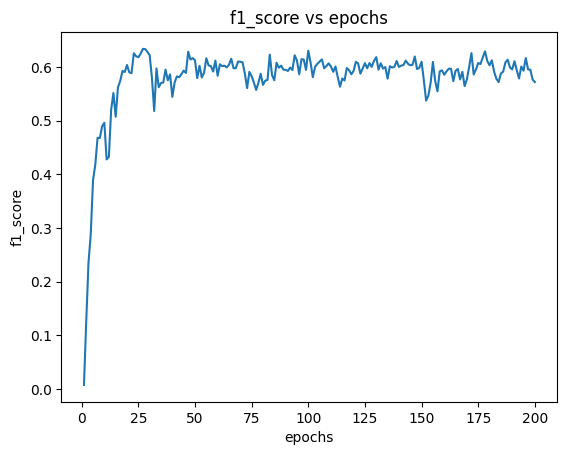

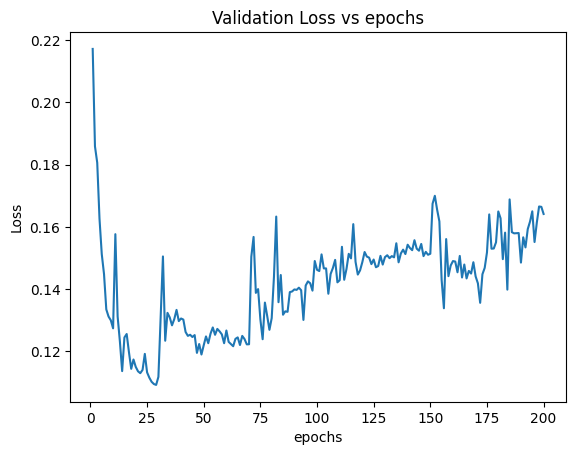

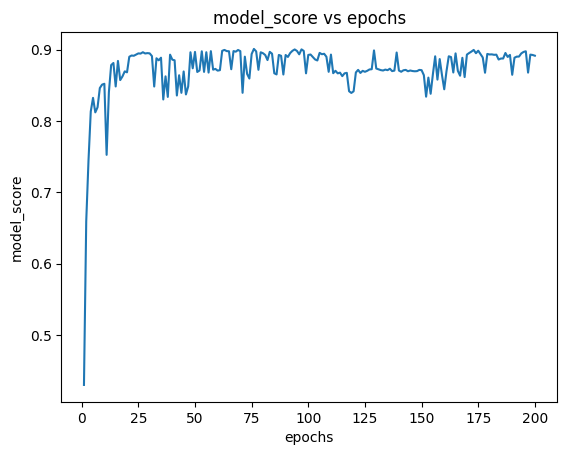

In [7]:
K = len(f1_arr)+1
plt.figure(1)
#plt.plot(sorted(list(set(roc_epochs))), f1_arr)
plt.plot(range(1,K), f1_arr)
plt.xlabel("epochs")
plt.ylabel("f1_score")
plt.title('f1_score vs epochs')

plt.figure(2)
#plt.plot(sorted(list(set(roc_epochs))), loss_arr)
plt.plot(range(1,K), loss_arr)
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.title('Validation Loss vs epochs')

plt.figure(3)
#plt.plot(sorted(list(set(roc_epochs))), f1_arr)
plt.plot(range(1,K), model_arr)
plt.xlabel("epochs")
plt.ylabel("model_score")
plt.title('model_score vs epochs')

print(max_ms)   

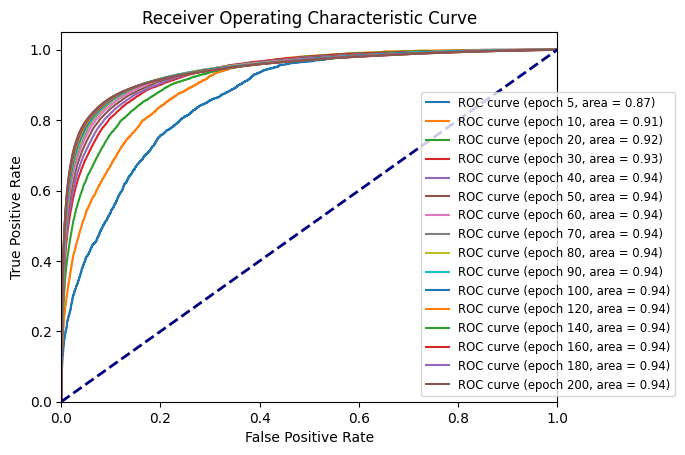

In [8]:
# plot ROC curve
fig2, ax2 = plt.subplots()
for i in range(len(roc_auc)):
    ax2.plot(roc_fpr[i], roc_tpr[i], label=f'ROC curve (epoch {roc_epochs[i]}, area = {roc_auc[i]:.2f})')
ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('Receiver Operating Characteristic Curve')
# Set the properties for the legend
legend = ax2.legend(loc='lower right', bbox_to_anchor=(1.25, 0), fontsize='small', framealpha=0.8)